# Chapter 08 - Hands-On Autoencoder (TensorFlow v 2.1.0)

## Setup 

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
#import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

#### Check library versions & set seed

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    0.20.3
tensorflow 2.1.0
keras      2.2.4-tf
numpy      1.17.2


In [3]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

## Data Preparation 

### Load the data

In [4]:
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [5]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

### Scale the data

In [6]:
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

### Split into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                     random_state=2018, stratify=dataY)

In [8]:
X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

### Define evaluation function and plotting function

In [9]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [10]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

## Model One 
#### Two layer complete autoencoder with linear activation

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [14]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0645 - accuracy: 0.9077 - val_loss: 0.0087 - val_accuracy: 0.9592
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0011 - accuracy: 0.9910 - val_loss: 2.3078e-07 - val_accuracy: 0.9997
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 5.0244e-04 - accuracy: 0.9953 - val_loss: 8.2655e-09 - val_accuracy: 1.0000
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.8131e-04 - accuracy: 0.9937 - val_loss: 1.8586e-05 - val_accuracy: 0.9982
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 7.8606e-04 - accuracy: 0.9942 - val_loss: 0.0017 - val_accuracy: 0.9954
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.2246e-04 - accuracy: 0.9942 - val_loss: 4.6100e-04 - val_accuracy: 0.9937
Epoch 7/10

### Evaluate on Test Set

93987/93987 [==============================] - 1s 11us/sample


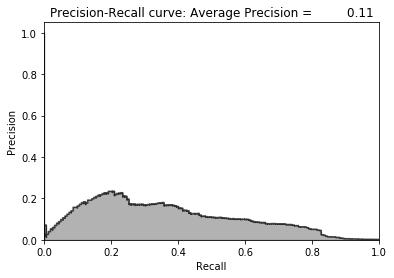

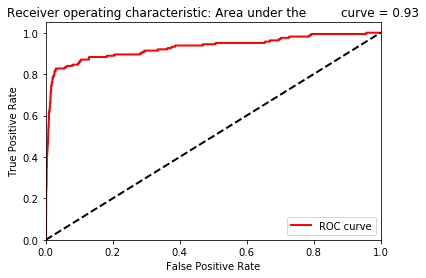

In [15]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0780 - accuracy: 0.8906 - val_loss: 0.0070 - val_accuracy: 0.9651
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0011 - accuracy: 0.9918 - val_loss: 2.5513e-08 - val_accuracy: 0.9999
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 6.3647e-04 - accuracy: 0.9953 - val_loss: 2.2728e-08 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 7.5037e-04 - accuracy: 0.9940 - val_loss: 2.7152e-05 - val_accuracy: 0.9976
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.8206e-04 - accuracy: 0.9940 - val_loss: 0.0015 - val_accuracy: 0.9969
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.2387e-04 - accuracy: 0.9939 - val_loss: 2.7469e-04 - val_accuracy: 0.9925
Epoch 7/10

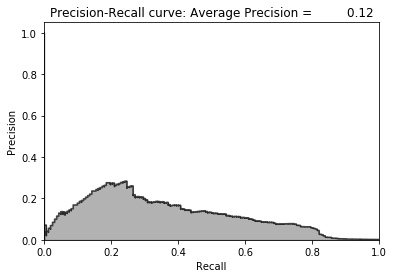

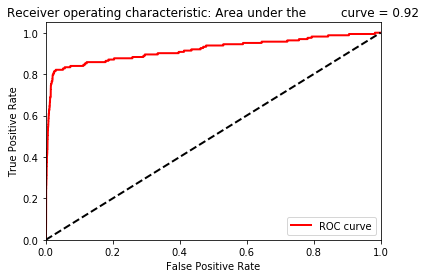

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0649 - accuracy: 0.9058 - val_loss: 0.0058 - val_accuracy: 0.9688
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.4438e-04 - accuracy: 0.9925 - val_loss: 6.2103e-08 - val_accuracy: 0.9999
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.7340e-04 - accuracy: 0.9947 - val_loss: 7.1049e-09 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.6923e-04 - accuracy: 0.9937 - val_loss: 2.6431e-04 - val_accuracy: 0.9936
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.6116e-04 - accuracy: 0.9937 - val_loss: 1.6930e-04 - val_accuracy: 0.9974
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.2201e-04 - accuracy: 0.9947 - val_loss: 3.2980e-04 - val_accuracy: 0.9946
Ep

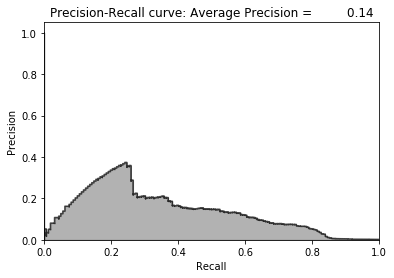

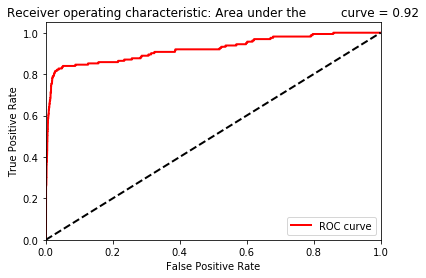

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0693 - accuracy: 0.9073 - val_loss: 0.0083 - val_accuracy: 0.9599
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0017 - accuracy: 0.9878 - val_loss: 2.0972e-05 - val_accuracy: 0.9987
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 4.9016e-04 - accuracy: 0.9952 - val_loss: 2.4484e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.8927e-04 - accuracy: 0.9935 - val_loss: 2.4676e-04 - val_accuracy: 0.9923
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 5.8915e-04 - accuracy: 0.9942 - val_loss: 7.3657e-04 - val_accuracy: 0.9960
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 4.9152e-04 - accuracy: 0.9940 - val_loss: 8.2533e-04 - val_accuracy: 0.9888
Epoch 

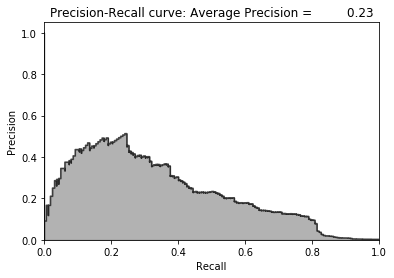

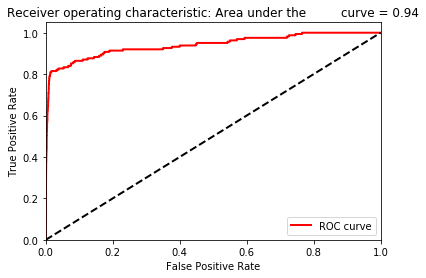

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0734 - accuracy: 0.8985 - val_loss: 0.0028 - val_accuracy: 0.9791
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0011 - accuracy: 0.9927 - val_loss: 5.5338e-07 - val_accuracy: 0.9997
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.2023e-04 - accuracy: 0.9952 - val_loss: 3.4819e-07 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.1664e-04 - accuracy: 0.9941 - val_loss: 4.6046e-05 - val_accuracy: 0.9972
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.5931e-04 - accuracy: 0.9944 - val_loss: 0.0012 - val_accuracy: 0.9962
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 5.1735e-04 - accuracy: 0.9950 - val_loss: 6.1278e-04 - val_accuracy: 0.9883
Epoch 7/10

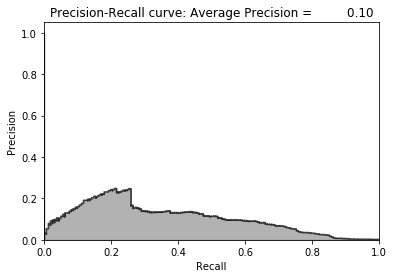

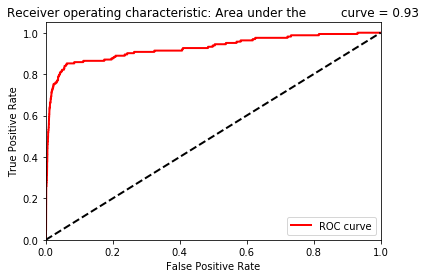

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0701 - accuracy: 0.9019 - val_loss: 8.6436e-04 - val_accuracy: 0.9874
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0011 - accuracy: 0.9927 - val_loss: 7.9656e-07 - val_accuracy: 0.9996
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.4553e-04 - accuracy: 0.9955 - val_loss: 1.9552e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.9261e-04 - accuracy: 0.9936 - val_loss: 2.7789e-06 - val_accuracy: 0.9992
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.4046e-04 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9971
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 5.8357e-04 - accuracy: 0.9950 - val_loss: 5.0797e-04 - val_accuracy: 0.9930
Epoch 

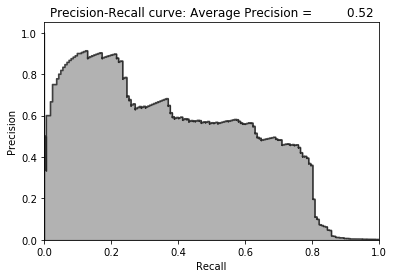

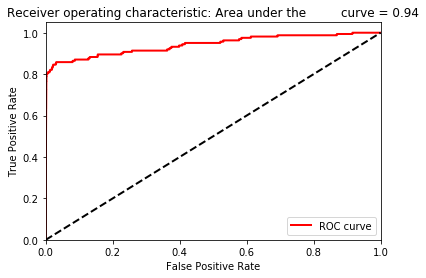

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0688 - accuracy: 0.9064 - val_loss: 0.0049 - val_accuracy: 0.9708
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0014 - accuracy: 0.9878 - val_loss: 6.9447e-06 - val_accuracy: 0.9988
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.7882e-04 - accuracy: 0.9945 - val_loss: 7.3872e-09 - val_accuracy: 1.0000
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 7.4183e-04 - accuracy: 0.9933 - val_loss: 2.0064e-06 - val_accuracy: 0.9995
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.0118e-04 - accuracy: 0.9945 - val_loss: 0.0015 - val_accuracy: 0.9970
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 5.4460e-04 - accuracy: 0.9949 - val_loss: 1.8971e-04 - val_accuracy: 0.9953
Epoch 7/10

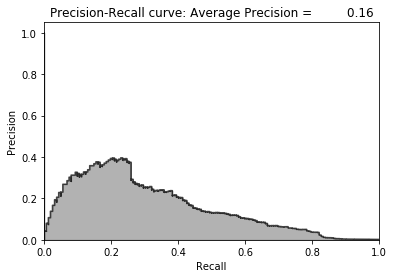

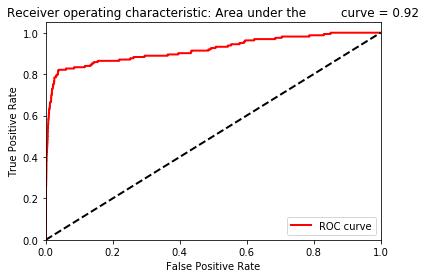

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0682 - accuracy: 0.9005 - val_loss: 0.0043 - val_accuracy: 0.9696
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 9.4874e-04 - accuracy: 0.9923 - val_loss: 5.2465e-06 - val_accuracy: 0.9991
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.2411e-04 - accuracy: 0.9951 - val_loss: 4.1855e-07 - val_accuracy: 0.9997
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.4609e-04 - accuracy: 0.9941 - val_loss: 2.1006e-05 - val_accuracy: 0.9981
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.2854e-04 - accuracy: 0.9945 - val_loss: 3.2742e-04 - val_accuracy: 0.9977
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.6661e-04 - accuracy: 0.9951 - val_loss: 6.3220e-04 - val_accuracy: 0.9882
Ep

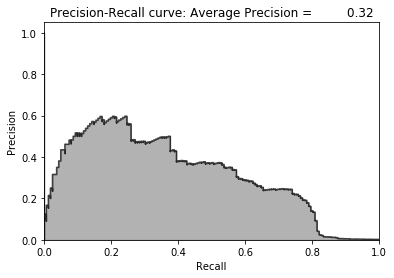

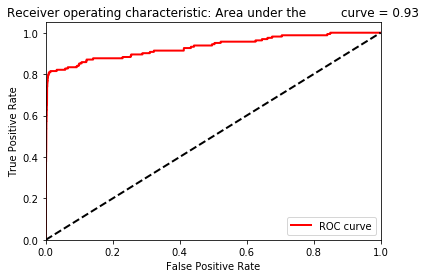

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0698 - accuracy: 0.9020 - val_loss: 0.0119 - val_accuracy: 0.9549
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0011 - accuracy: 0.9906 - val_loss: 1.7046e-06 - val_accuracy: 0.9994
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.6384e-04 - accuracy: 0.9940 - val_loss: 1.4786e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.9900e-04 - accuracy: 0.9943 - val_loss: 3.4956e-05 - val_accuracy: 0.9981
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 5.6565e-04 - accuracy: 0.9948 - val_loss: 5.7780e-04 - val_accuracy: 0.9970
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 4.8622e-04 - accuracy: 0.9946 - val_loss: 4.0873e-04 - val_accuracy: 0.9929
Epoch 

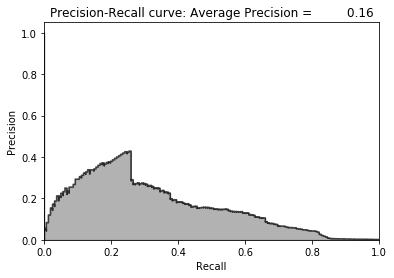

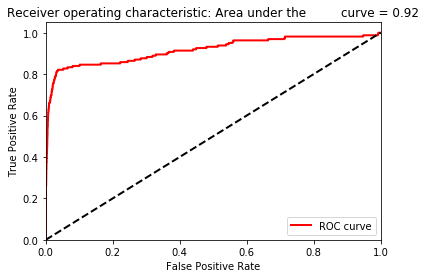

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0686 - accuracy: 0.9066 - val_loss: 0.0070 - val_accuracy: 0.9641
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0013 - accuracy: 0.9915 - val_loss: 2.1696e-06 - val_accuracy: 0.9993
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.5124e-04 - accuracy: 0.9948 - val_loss: 1.0744e-07 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 6.2027e-04 - accuracy: 0.9935 - val_loss: 2.9234e-05 - val_accuracy: 0.9977
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 6.8334e-04 - accuracy: 0.9944 - val_loss: 0.0010 - val_accuracy: 0.9967
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 5.0456e-04 - accuracy: 0.9941 - val_loss: 3.9494e-04 - val_accuracy: 0.9938
Epoch 7/10

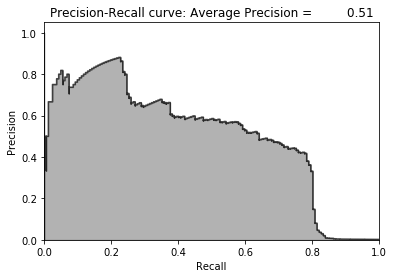

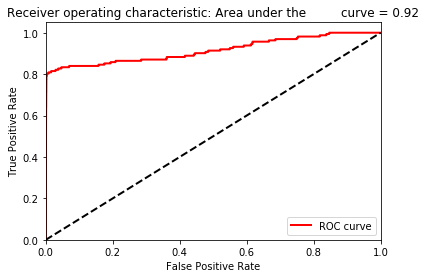

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0650 - accuracy: 0.9138 - val_loss: 0.0040 - val_accuracy: 0.9708
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 9.5937e-04 - accuracy: 0.9917 - val_loss: 9.1012e-08 - val_accuracy: 0.9998
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.0518e-04 - accuracy: 0.9948 - val_loss: 4.7120e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 4.9217e-04 - accuracy: 0.9945 - val_loss: 2.3504e-05 - val_accuracy: 0.9983
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.4480e-04 - accuracy: 0.9944 - val_loss: 4.2283e-04 - val_accuracy: 0.9968
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 4.3965e-04 - accuracy: 0.9940 - val_loss: 5.2493e-04 - val_accuracy: 0.9903
Ep

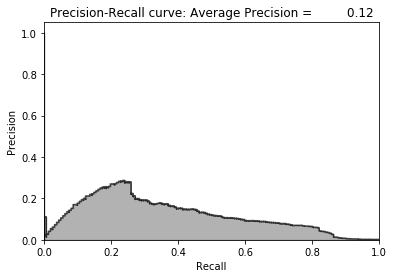

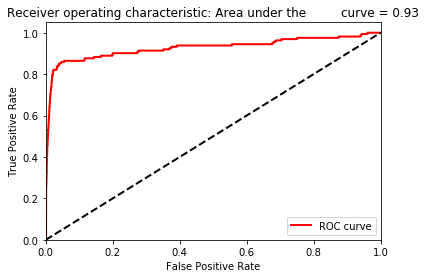

Mean average precision over 10 runs: 0.23826597710033526


[0.122, 0.1379, 0.2327, 0.1036, 0.5221, 0.1592, 0.3162, 0.1619, 0.5074, 0.1197]

In [16]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [17]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2383
Coefficient of variation over 10 runs: 0.6324


[0.122, 0.1379, 0.2327, 0.1036, 0.5221, 0.1592, 0.3162, 0.1619, 0.5074, 0.1197]

## Model Two
#### Two layer undercomplete autoencoder with linear activation
20 nodes in hidden layer

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.3345 - accuracy: 0.5817 - val_loss: 0.2787 - val_accuracy: 0.5897
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2810 - accuracy: 0.5982 - val_loss: 0.2752 - val_accuracy: 0.5990
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.2789 - accuracy: 0.6067 - val_loss: 0.2746 - val_accuracy: 0.5968
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2778 - accuracy: 0.5949 - val_loss: 0.2752 - val_accuracy: 0.5982
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2779 - accuracy: 0.6026 - val_loss: 0.2746 - val_accuracy: 0.5972
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2778 - accuracy: 0.6024 - val_loss: 0.2749 - val_accuracy: 0.5985
Epoch 7/10
190820/190820 [================

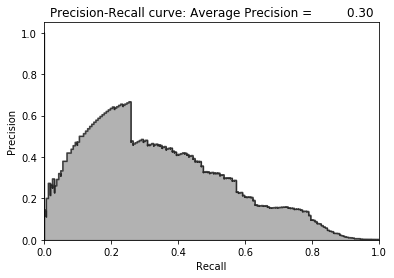

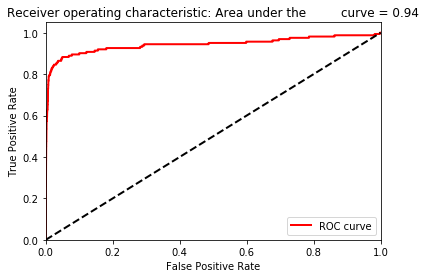

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3347 - accuracy: 0.5546 - val_loss: 0.2802 - val_accuracy: 0.5822
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2822 - accuracy: 0.5821 - val_loss: 0.2756 - val_accuracy: 0.5807
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2794 - accuracy: 0.5703 - val_loss: 0.2750 - val_accuracy: 0.5700
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5776 - val_loss: 0.2752 - val_accuracy: 0.5731
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2785 - accuracy: 0.5776 - val_loss: 0.2750 - val_accuracy: 0.5784
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5890 - val_loss: 0.2754 - val_accuracy: 0.5798
Epoch 7/10
190820/190820 [================

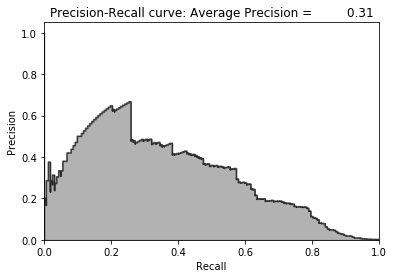

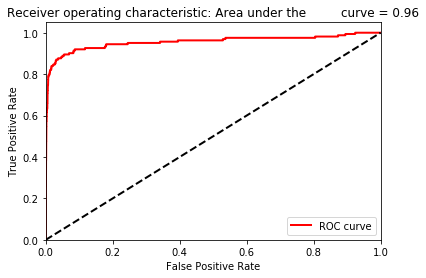

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3289 - accuracy: 0.5795 - val_loss: 0.2798 - val_accuracy: 0.5987
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2825 - accuracy: 0.5975 - val_loss: 0.2758 - val_accuracy: 0.5836
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2799 - accuracy: 0.5815 - val_loss: 0.2752 - val_accuracy: 0.5769
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2787 - accuracy: 0.5798 - val_loss: 0.2754 - val_accuracy: 0.5792
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2785 - accuracy: 0.5806 - val_loss: 0.2749 - val_accuracy: 0.5816
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2783 - accuracy: 0.5900 - val_loss: 0.2751 - val_accuracy: 0.5894
Epoch 7/10
190820/190820 [================

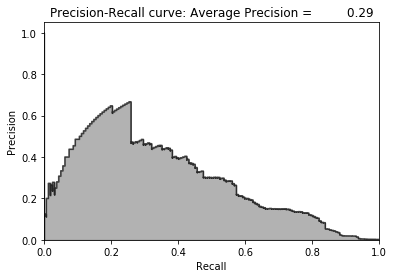

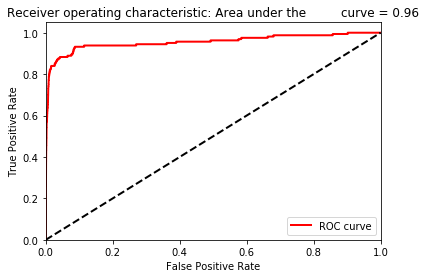

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.3309 - accuracy: 0.5428 - val_loss: 0.2805 - val_accuracy: 0.5677
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2816 - accuracy: 0.5611 - val_loss: 0.2759 - val_accuracy: 0.5602
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2794 - accuracy: 0.5552 - val_loss: 0.2750 - val_accuracy: 0.5577
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2783 - accuracy: 0.5588 - val_loss: 0.2755 - val_accuracy: 0.5546
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5617 - val_loss: 0.2752 - val_accuracy: 0.5663
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2782 - accuracy: 0.5738 - val_loss: 0.2754 - val_accuracy: 0.5694
Epoch 7/10
190820/190820 [================

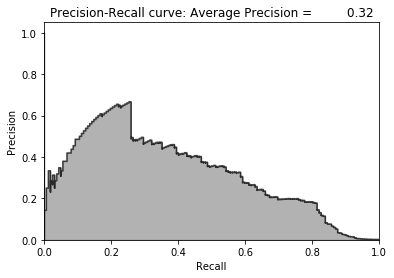

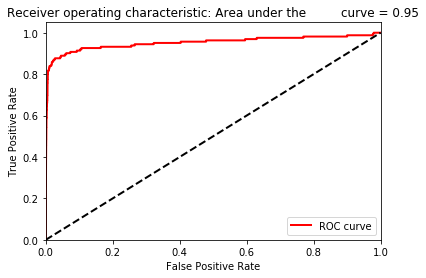

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.3376 - accuracy: 0.5348 - val_loss: 0.2805 - val_accuracy: 0.5551
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2825 - accuracy: 0.5582 - val_loss: 0.2759 - val_accuracy: 0.5599
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.2796 - accuracy: 0.5645 - val_loss: 0.2752 - val_accuracy: 0.5660
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2786 - accuracy: 0.5720 - val_loss: 0.2757 - val_accuracy: 0.5761
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2788 - accuracy: 0.5826 - val_loss: 0.2751 - val_accuracy: 0.5787
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2786 - accuracy: 0.5901 - val_loss: 0.2753 - val_accuracy: 0.5855
Epoch 7/10
190820/190820 [================

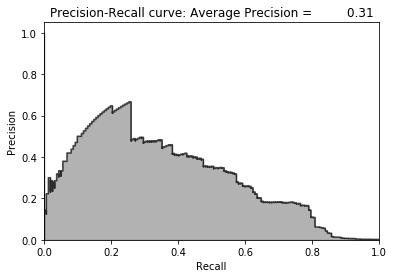

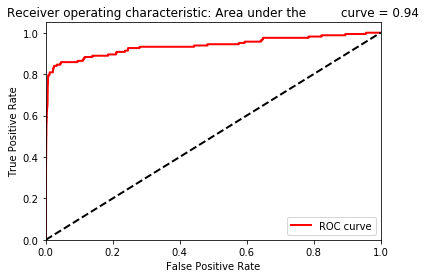

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3380 - accuracy: 0.5759 - val_loss: 0.2805 - val_accuracy: 0.5796
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2826 - accuracy: 0.5647 - val_loss: 0.2759 - val_accuracy: 0.5649
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2799 - accuracy: 0.5492 - val_loss: 0.2751 - val_accuracy: 0.5387
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5370 - val_loss: 0.2756 - val_accuracy: 0.5466
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2786 - accuracy: 0.5480 - val_loss: 0.2750 - val_accuracy: 0.5426
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2783 - accuracy: 0.5459 - val_loss: 0.2752 - val_accuracy: 0.5450
Epoch 7/10
190820/190820 [================

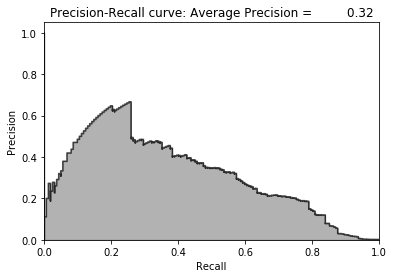

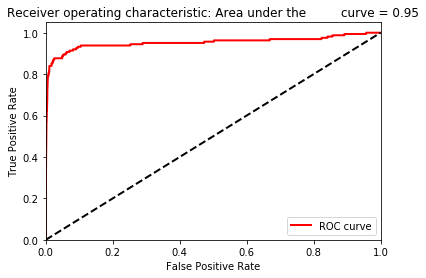

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3284 - accuracy: 0.5278 - val_loss: 0.2799 - val_accuracy: 0.5332
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2821 - accuracy: 0.5441 - val_loss: 0.2759 - val_accuracy: 0.5418
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2793 - accuracy: 0.5460 - val_loss: 0.2751 - val_accuracy: 0.5343
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2783 - accuracy: 0.5281 - val_loss: 0.2761 - val_accuracy: 0.5319
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2786 - accuracy: 0.5387 - val_loss: 0.2754 - val_accuracy: 0.5432
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5587 - val_loss: 0.2754 - val_accuracy: 0.5490
Epoch 7/10
190820/190820 [================

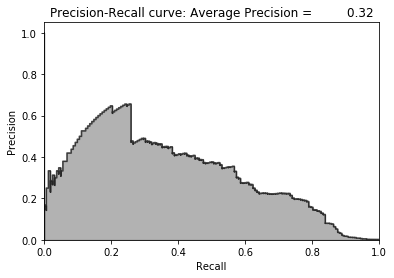

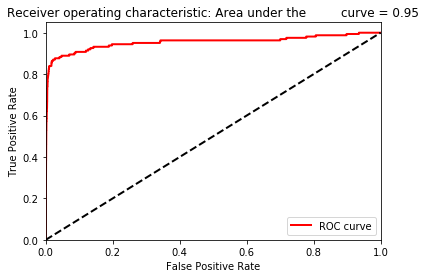

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3454 - accuracy: 0.5296 - val_loss: 0.2799 - val_accuracy: 0.5559
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2821 - accuracy: 0.5579 - val_loss: 0.2758 - val_accuracy: 0.5596
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2797 - accuracy: 0.5554 - val_loss: 0.2751 - val_accuracy: 0.5600
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5601 - val_loss: 0.2752 - val_accuracy: 0.5565
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2785 - accuracy: 0.5769 - val_loss: 0.2746 - val_accuracy: 0.5701
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2784 - accuracy: 0.5880 - val_loss: 0.2751 - val_accuracy: 0.5733
Epoch 7/10
190820/190820 [================

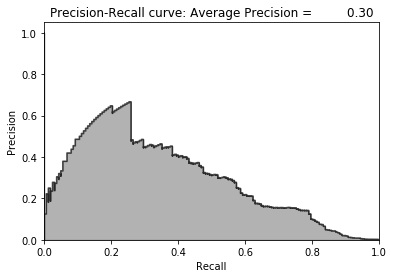

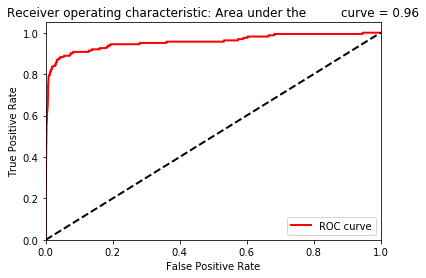

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3300 - accuracy: 0.5640 - val_loss: 0.2805 - val_accuracy: 0.5790
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2819 - accuracy: 0.5821 - val_loss: 0.2755 - val_accuracy: 0.5816
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2791 - accuracy: 0.5857 - val_loss: 0.2748 - val_accuracy: 0.5828
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2781 - accuracy: 0.5814 - val_loss: 0.2755 - val_accuracy: 0.5837
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2781 - accuracy: 0.5854 - val_loss: 0.2746 - val_accuracy: 0.5820
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2779 - accuracy: 0.5885 - val_loss: 0.2751 - val_accuracy: 0.5905
Epoch 7/10
190820/190820 [================

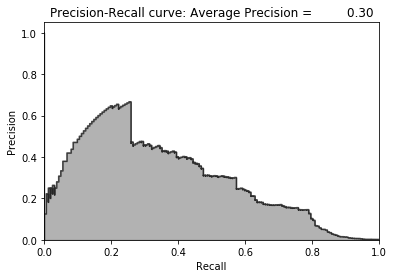

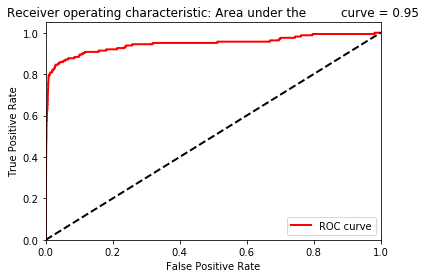

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.3344 - accuracy: 0.5476 - val_loss: 0.2807 - val_accuracy: 0.5760
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2824 - accuracy: 0.5918 - val_loss: 0.2760 - val_accuracy: 0.5909
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2795 - accuracy: 0.5957 - val_loss: 0.2753 - val_accuracy: 0.5968
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2784 - accuracy: 0.5969 - val_loss: 0.2757 - val_accuracy: 0.6023
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.2783 - accuracy: 0.5971 - val_loss: 0.2751 - val_accuracy: 0.5967
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.2781 - accuracy: 0.5998 - val_loss: 0.2752 - val_accuracy: 0.6050
Epoch 7/10
190820/190820 [================

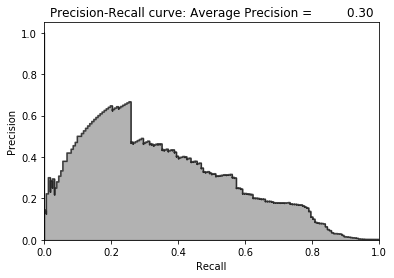

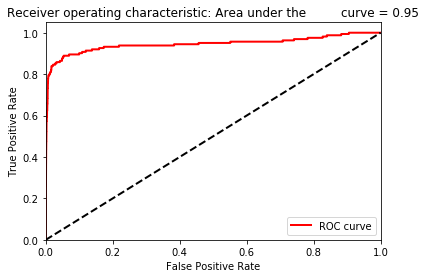

Mean average precision over 10 runs: 0.307


[0.2968, 0.3148, 0.2921, 0.3226, 0.3092, 0.316, 0.3229, 0.2964, 0.2963, 0.3027]

In [20]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [22]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.307
Coefficient of variation over 10 runs: 0.0359


[0.2968, 0.3148, 0.2921, 0.3226, 0.3092, 0.316, 0.3229, 0.2964, 0.2963, 0.3027]

## Model Two v2
#### Two layer undercomplete autoencoder with linear activation 
With 27 nodes this time 

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1041 - accuracy: 0.8379 - val_loss: 0.0385 - val_accuracy: 0.8976
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0379 - accuracy: 0.9234 - val_loss: 0.0350 - val_accuracy: 0.9341
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0379 - accuracy: 0.9306 - val_loss: 0.0347 - val_accuracy: 0.9520
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0356 - accuracy: 0.9555 - val_loss: 0.0355 - val_accuracy: 0.9173
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0364 - accuracy: 0.9403 - val_loss: 0.0348 - val_accuracy: 0.9561
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0358 - accuracy: 0.9518 - val_loss: 0.0339 - val_accuracy: 0.9587
Epoch 7/10
190820/190820 [================

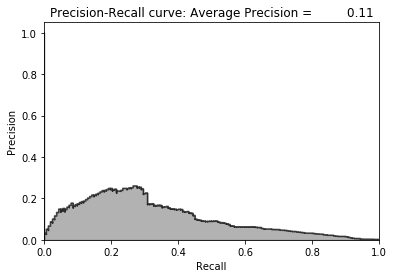

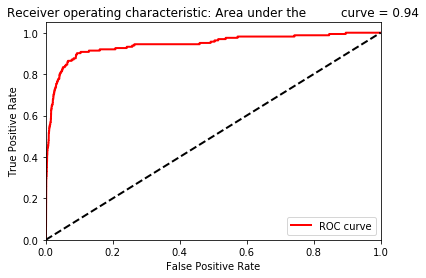

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1016 - accuracy: 0.8379 - val_loss: 0.0422 - val_accuracy: 0.8891
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0407 - accuracy: 0.9229 - val_loss: 0.0361 - val_accuracy: 0.9300
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0389 - accuracy: 0.9430 - val_loss: 0.0363 - val_accuracy: 0.9561
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0388 - accuracy: 0.9472 - val_loss: 0.0373 - val_accuracy: 0.9512
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0386 - accuracy: 0.9568 - val_loss: 0.0369 - val_accuracy: 0.9505
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0390 - accuracy: 0.9587 - val_loss: 0.0369 - val_accuracy: 0.9633
Epoch 7/10
190820/190820 [================

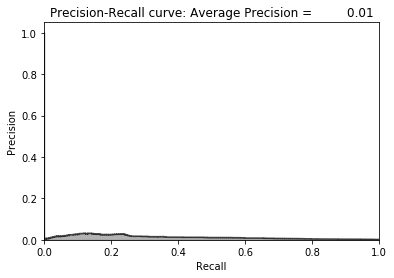

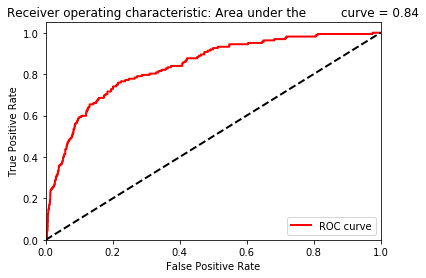

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1113 - accuracy: 0.8338 - val_loss: 0.0438 - val_accuracy: 0.9171
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0403 - accuracy: 0.9458 - val_loss: 0.0365 - val_accuracy: 0.9470
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0388 - accuracy: 0.9507 - val_loss: 0.0364 - val_accuracy: 0.9623
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0389 - accuracy: 0.9558 - val_loss: 0.0374 - val_accuracy: 0.9609
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0387 - accuracy: 0.9633 - val_loss: 0.0368 - val_accuracy: 0.9579
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0391 - accuracy: 0.9588 - val_loss: 0.0368 - val_accuracy: 0.9665
Epoch 7/10
190820/190820 [================

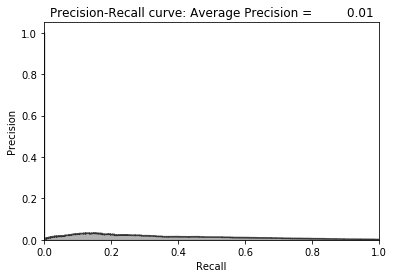

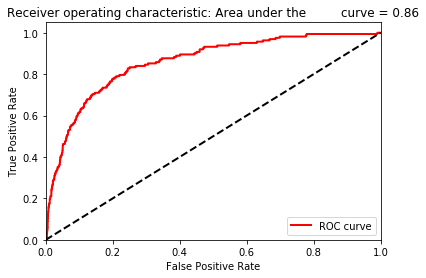

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1047 - accuracy: 0.8342 - val_loss: 0.0428 - val_accuracy: 0.9214
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0401 - accuracy: 0.9563 - val_loss: 0.0365 - val_accuracy: 0.9630
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0386 - accuracy: 0.9586 - val_loss: 0.0364 - val_accuracy: 0.9671
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0385 - accuracy: 0.9578 - val_loss: 0.0377 - val_accuracy: 0.9559
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0388 - accuracy: 0.9606 - val_loss: 0.0369 - val_accuracy: 0.9578
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0390 - accuracy: 0.9577 - val_loss: 0.0371 - val_accuracy: 0.9654
Epoch 7/10
190820/190820 [================

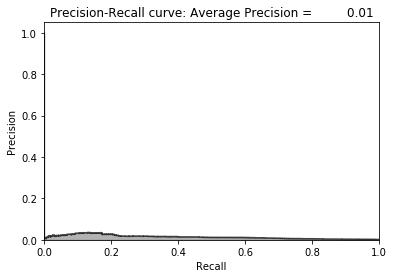

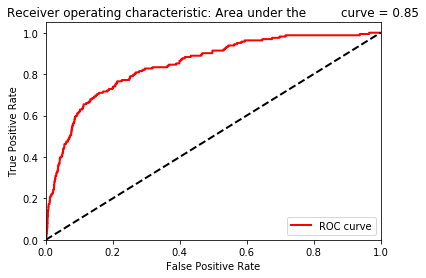

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1066 - accuracy: 0.8328 - val_loss: 0.0460 - val_accuracy: 0.9154
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0407 - accuracy: 0.9426 - val_loss: 0.0363 - val_accuracy: 0.9523
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0389 - accuracy: 0.9556 - val_loss: 0.0365 - val_accuracy: 0.9669
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0387 - accuracy: 0.9592 - val_loss: 0.0375 - val_accuracy: 0.9592
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0386 - accuracy: 0.9640 - val_loss: 0.0368 - val_accuracy: 0.9598
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0392 - accuracy: 0.9608 - val_loss: 0.0370 - val_accuracy: 0.9681
Epoch 7/10
190820/190820 [================

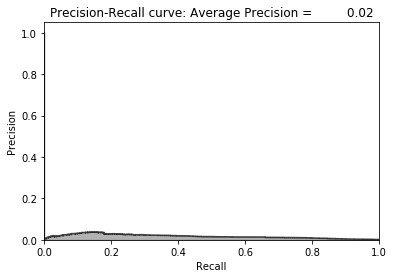

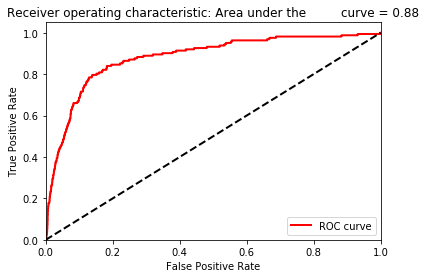

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.1032 - accuracy: 0.8239 - val_loss: 0.0413 - val_accuracy: 0.9075
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0404 - accuracy: 0.9418 - val_loss: 0.0363 - val_accuracy: 0.9516
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9536 - val_loss: 0.0365 - val_accuracy: 0.9615
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0387 - accuracy: 0.9560 - val_loss: 0.0376 - val_accuracy: 0.9577
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0389 - accuracy: 0.9582 - val_loss: 0.0374 - val_accuracy: 0.9587
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0392 - accuracy: 0.9597 - val_loss: 0.0371 - val_accuracy: 0.9643
Epoch 7/10
190820/190820 [================

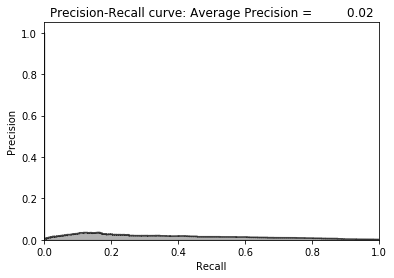

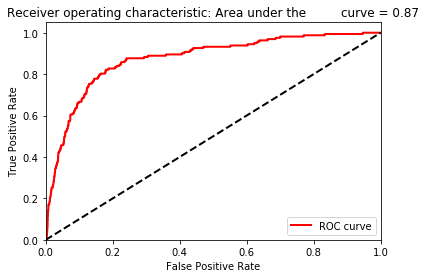

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1028 - accuracy: 0.8168 - val_loss: 0.0392 - val_accuracy: 0.8690
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0407 - accuracy: 0.9120 - val_loss: 0.0359 - val_accuracy: 0.9241
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0391 - accuracy: 0.9372 - val_loss: 0.0362 - val_accuracy: 0.9487
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0388 - accuracy: 0.9440 - val_loss: 0.0374 - val_accuracy: 0.9480
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0385 - accuracy: 0.9558 - val_loss: 0.0369 - val_accuracy: 0.9534
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9568 - val_loss: 0.0369 - val_accuracy: 0.9629
Epoch 7/10
190820/190820 [================

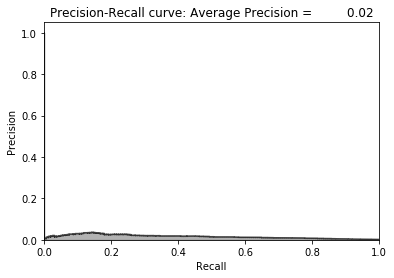

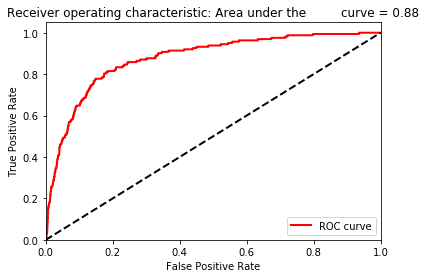

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1180 - accuracy: 0.8178 - val_loss: 0.0430 - val_accuracy: 0.9031
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0402 - accuracy: 0.9352 - val_loss: 0.0363 - val_accuracy: 0.9465
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0388 - accuracy: 0.9518 - val_loss: 0.0364 - val_accuracy: 0.9600
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0387 - accuracy: 0.9550 - val_loss: 0.0375 - val_accuracy: 0.9585
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0387 - accuracy: 0.9617 - val_loss: 0.0369 - val_accuracy: 0.9582
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9608 - val_loss: 0.0368 - val_accuracy: 0.9677
Epoch 7/10
190820/190820 [================

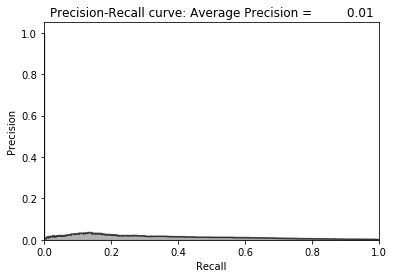

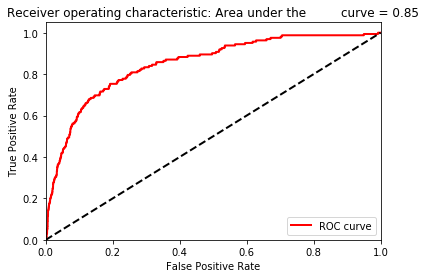

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1011 - accuracy: 0.8236 - val_loss: 0.0392 - val_accuracy: 0.8846
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0407 - accuracy: 0.9139 - val_loss: 0.0360 - val_accuracy: 0.9189
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0395 - accuracy: 0.9387 - val_loss: 0.0364 - val_accuracy: 0.9546
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0383 - accuracy: 0.9510 - val_loss: 0.0379 - val_accuracy: 0.9518
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0389 - accuracy: 0.9586 - val_loss: 0.0371 - val_accuracy: 0.9572
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9592 - val_loss: 0.0368 - val_accuracy: 0.9658
Epoch 7/10
190820/190820 [================

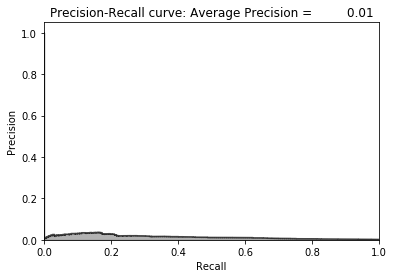

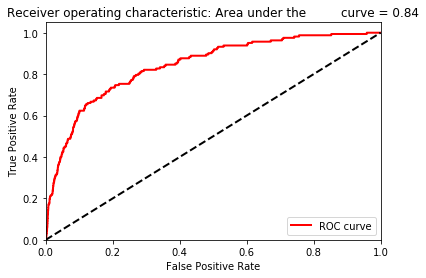

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1133 - accuracy: 0.8111 - val_loss: 0.0395 - val_accuracy: 0.8660
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0415 - accuracy: 0.9230 - val_loss: 0.0360 - val_accuracy: 0.9407
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0393 - accuracy: 0.9482 - val_loss: 0.0364 - val_accuracy: 0.9621
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0387 - accuracy: 0.9528 - val_loss: 0.0374 - val_accuracy: 0.9541
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0386 - accuracy: 0.9603 - val_loss: 0.0371 - val_accuracy: 0.9594
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9587 - val_loss: 0.0369 - val_accuracy: 0.9663
Epoch 7/10
190820/190820 [================

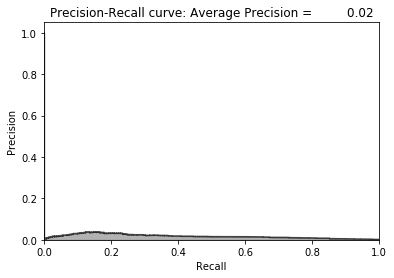

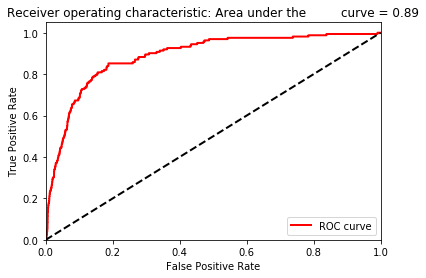

Mean average precision over 10 runs: 0.024


[0.1068, 0.0126, 0.014, 0.0138, 0.017, 0.0156, 0.0157, 0.0136, 0.014, 0.017]

In [24]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [25]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.024
Coefficient of variation over 10 runs: 1.1499


[0.1068, 0.0126, 0.014, 0.0138, 0.017, 0.0156, 0.0157, 0.0136, 0.014, 0.017]

## Model Three
#### Three layer undercomplete autoencoder with linear activation.
With 28 and 27 nodes in the two hidden layers, respectively

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1132 - accuracy: 0.8038 - val_loss: 0.0530 - val_accuracy: 0.9025
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0415 - accuracy: 0.9361 - val_loss: 0.0364 - val_accuracy: 0.9449
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0392 - accuracy: 0.9478 - val_loss: 0.0363 - val_accuracy: 0.9627
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0394 - accuracy: 0.9527 - val_loss: 0.0382 - val_accuracy: 0.9529
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0391 - accuracy: 0.9554 - val_loss: 0.0403 - val_accuracy: 0.9529
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0395 - accuracy: 0.9557 - val_loss: 0.0373 - val_accuracy: 0.9611
Epoch 7/10
190820/190820 [================

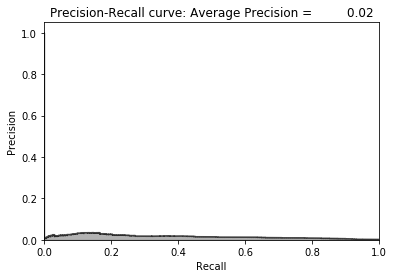

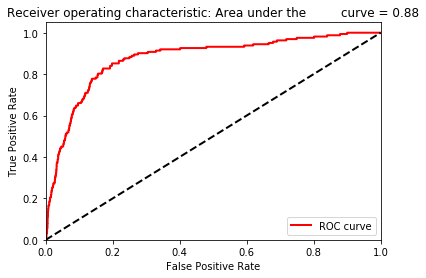

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.1020 - accuracy: 0.8171 - val_loss: 0.0402 - val_accuracy: 0.8913
Epoch 2/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.0414 - accuracy: 0.9302 - val_loss: 0.0364 - val_accuracy: 0.9400
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0394 - accuracy: 0.9481 - val_loss: 0.0365 - val_accuracy: 0.9620
Epoch 4/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0391 - accuracy: 0.9547 - val_loss: 0.0382 - val_accuracy: 0.9574
Epoch 5/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0395 - accuracy: 0.9611 - val_loss: 0.0382 - val_accuracy: 0.9555
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0397 - accuracy: 0.9592 - val_loss: 0.0374 - val_accuracy: 0.9655
Epoch 7/10
190820/190820 [================

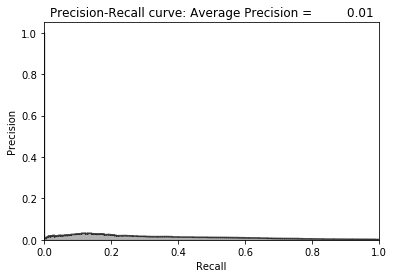

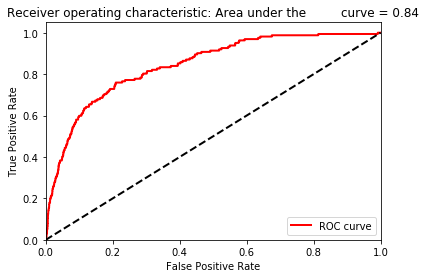

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.1045 - accuracy: 0.8313 - val_loss: 0.0530 - val_accuracy: 0.9058
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0412 - accuracy: 0.9375 - val_loss: 0.0361 - val_accuracy: 0.9404
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0397 - accuracy: 0.9460 - val_loss: 0.0365 - val_accuracy: 0.9572
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0393 - accuracy: 0.9520 - val_loss: 0.0387 - val_accuracy: 0.9552
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0396 - accuracy: 0.9568 - val_loss: 0.0382 - val_accuracy: 0.9559
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0398 - accuracy: 0.9560 - val_loss: 0.0373 - val_accuracy: 0.9640
Epoch 7/10
190820/190820 [================

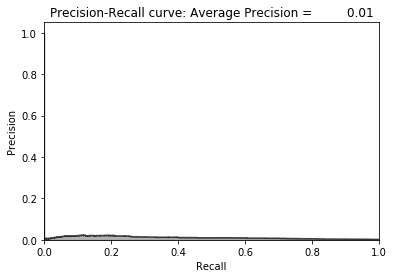

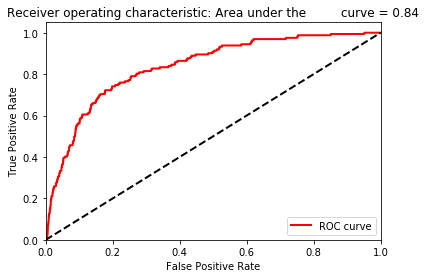

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.1123 - accuracy: 0.8032 - val_loss: 0.0443 - val_accuracy: 0.8681
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0372 - accuracy: 0.9200 - val_loss: 0.0343 - val_accuracy: 0.9319
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0391 - accuracy: 0.9266 - val_loss: 0.0347 - val_accuracy: 0.9371
Epoch 4/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0365 - accuracy: 0.9472 - val_loss: 0.0359 - val_accuracy: 0.9326
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0366 - accuracy: 0.9352 - val_loss: 0.0352 - val_accuracy: 0.9452
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0365 - accuracy: 0.9466 - val_loss: 0.0339 - val_accuracy: 0.9553
Epoch 7/10
190820/190820 [================

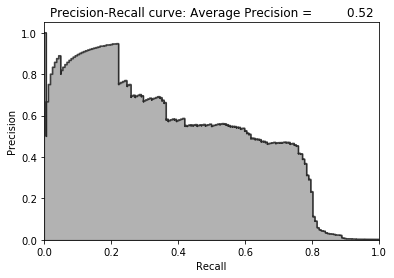

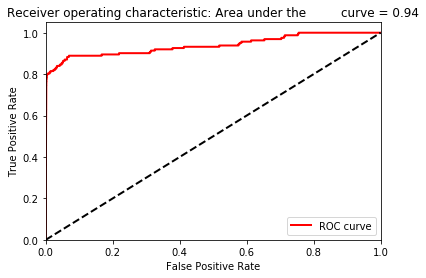

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1006 - accuracy: 0.8447 - val_loss: 0.0526 - val_accuracy: 0.8954
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0398 - accuracy: 0.9290 - val_loss: 0.0357 - val_accuracy: 0.9327
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0383 - accuracy: 0.9346 - val_loss: 0.0358 - val_accuracy: 0.9407
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0392 - accuracy: 0.9126 - val_loss: 0.0374 - val_accuracy: 0.8719
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0381 - accuracy: 0.8749 - val_loss: 0.0376 - val_accuracy: 0.8866
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0379 - accuracy: 0.8890 - val_loss: 0.0352 - val_accuracy: 0.8961
Epoch 7/10
190820/190820 [================

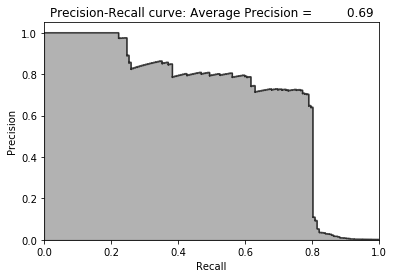

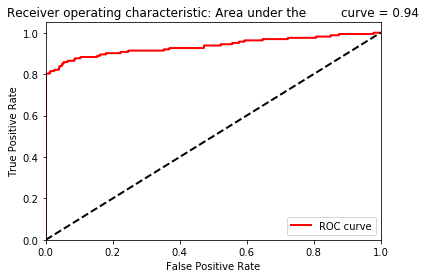

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1168 - accuracy: 0.8030 - val_loss: 0.0506 - val_accuracy: 0.8878
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0412 - accuracy: 0.9433 - val_loss: 0.0365 - val_accuracy: 0.9563
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0393 - accuracy: 0.9505 - val_loss: 0.0364 - val_accuracy: 0.9624
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0392 - accuracy: 0.9523 - val_loss: 0.0379 - val_accuracy: 0.9613
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0395 - accuracy: 0.9627 - val_loss: 0.0371 - val_accuracy: 0.9617
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0395 - accuracy: 0.9580 - val_loss: 0.0371 - val_accuracy: 0.9656
Epoch 7/10
190820/190820 [================

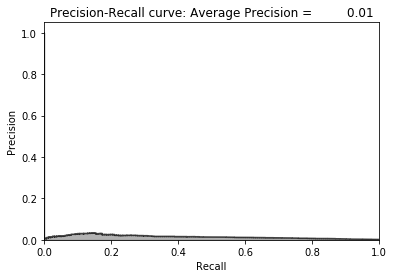

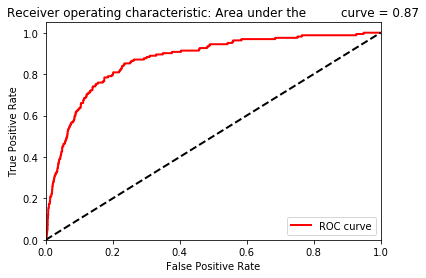

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1037 - accuracy: 0.8370 - val_loss: 0.0417 - val_accuracy: 0.9016
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0379 - accuracy: 0.9180 - val_loss: 0.0341 - val_accuracy: 0.9165
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0365 - accuracy: 0.9207 - val_loss: 0.0343 - val_accuracy: 0.9485
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0358 - accuracy: 0.9522 - val_loss: 0.0388 - val_accuracy: 0.9041
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0377 - accuracy: 0.9364 - val_loss: 0.0350 - val_accuracy: 0.9475
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0363 - accuracy: 0.9440 - val_loss: 0.0340 - val_accuracy: 0.9553
Epoch 7/10
190820/190820 [================

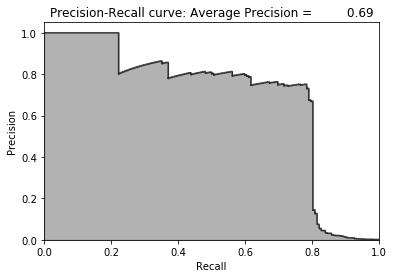

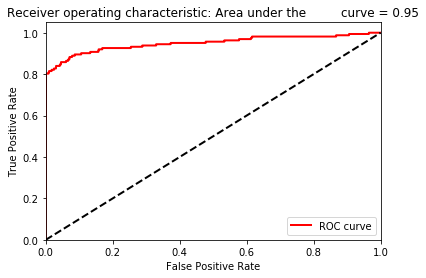

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1191 - accuracy: 0.8272 - val_loss: 0.0499 - val_accuracy: 0.8773
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0421 - accuracy: 0.9189 - val_loss: 0.0364 - val_accuracy: 0.9303
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0400 - accuracy: 0.9469 - val_loss: 0.0365 - val_accuracy: 0.9629
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0396 - accuracy: 0.9566 - val_loss: 0.0381 - val_accuracy: 0.9575
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0395 - accuracy: 0.9602 - val_loss: 0.0383 - val_accuracy: 0.9547
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0397 - accuracy: 0.9575 - val_loss: 0.0370 - val_accuracy: 0.9654
Epoch 7/10
190820/190820 [================

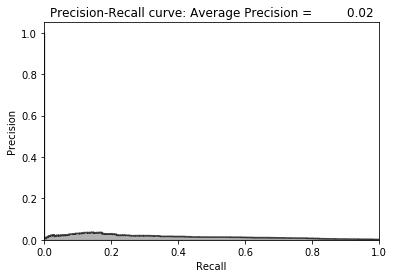

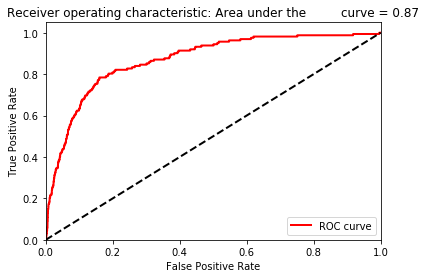

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.1107 - accuracy: 0.7956 - val_loss: 0.0523 - val_accuracy: 0.8947
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0409 - accuracy: 0.9415 - val_loss: 0.0364 - val_accuracy: 0.9522
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0395 - accuracy: 0.9524 - val_loss: 0.0365 - val_accuracy: 0.9611
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9533 - val_loss: 0.0378 - val_accuracy: 0.9530
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0396 - accuracy: 0.9534 - val_loss: 0.0397 - val_accuracy: 0.9574
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0397 - accuracy: 0.9578 - val_loss: 0.0369 - val_accuracy: 0.9664
Epoch 7/10
190820/190820 [================

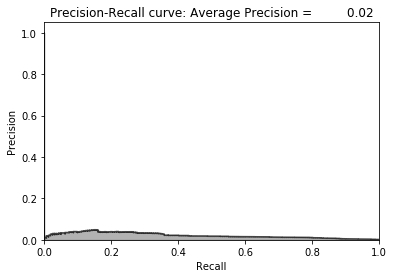

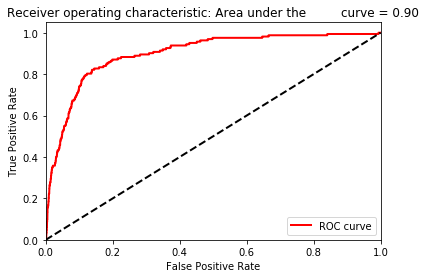

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1120 - accuracy: 0.7956 - val_loss: 0.0412 - val_accuracy: 0.8826
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0401 - accuracy: 0.9006 - val_loss: 0.0348 - val_accuracy: 0.8931
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0386 - accuracy: 0.9047 - val_loss: 0.0347 - val_accuracy: 0.9173
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0359 - accuracy: 0.9425 - val_loss: 0.0365 - val_accuracy: 0.9260
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0372 - accuracy: 0.9307 - val_loss: 0.0353 - val_accuracy: 0.9427
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0368 - accuracy: 0.9427 - val_loss: 0.0340 - val_accuracy: 0.9518
Epoch 7/10
190820/190820 [================

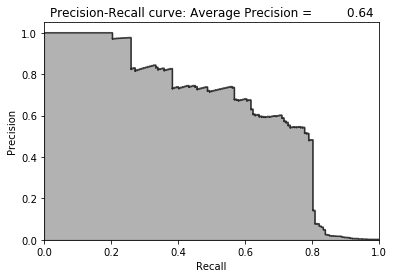

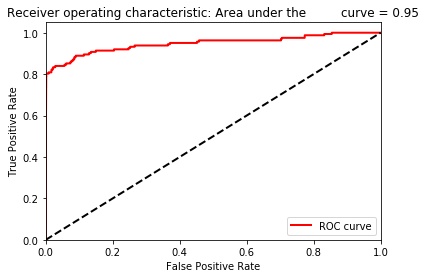

Mean average precision over 10 runs: 0.2627


[0.0155, 0.013, 0.0106, 0.5249, 0.6855, 0.0143, 0.6876, 0.0151, 0.0212, 0.6395]

In [27]:
# 10 runs - We will capture mean of average precision
tf.random.set_seed(42)
np.random.seed(42)
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [28]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2627
Coefficient of variation over 10 runs: 1.1659


[0.0155, 0.013, 0.0106, 0.5249, 0.6855, 0.0143, 0.6876, 0.0151, 0.0212, 0.6395]

## Model Four
#### Four layer undercomplete autoencoder with ReLu activation
29 -> 27 -> 22 -> 27 -> 29

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 42us/sample - loss: 0.6736 - accuracy: 0.6373 - val_loss: 0.6169 - val_accuracy: 0.7403
Epoch 2/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6078 - accuracy: 0.7918 - val_loss: 0.6027 - val_accuracy: 0.8075
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.6031 - accuracy: 0.8070 - val_loss: 0.6004 - val_accuracy: 0.8260
Epoch 4/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.6020 - accuracy: 0.8137 - val_loss: 0.6006 - val_accuracy: 0.8220
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.6012 - accuracy: 0.8146 - val_loss: 0.5991 - val_accuracy: 0.8322
Epoch 6/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.6035 - accuracy: 0.8140 - val_loss: 0.5986 - val_accuracy: 0.8382
Epoch 7/10
190820/190820 [================

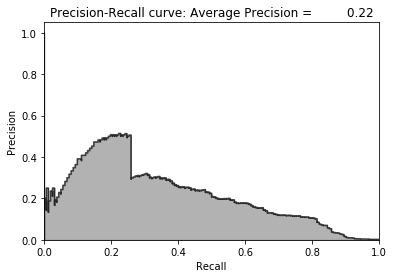

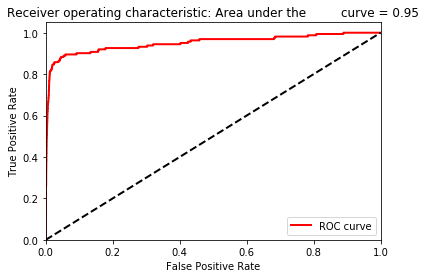

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6536 - accuracy: 0.6346 - val_loss: 0.5978 - val_accuracy: 0.7289
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5781 - accuracy: 0.7907 - val_loss: 0.5680 - val_accuracy: 0.8150
Epoch 3/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5666 - accuracy: 0.8112 - val_loss: 0.5587 - val_accuracy: 0.8327
Epoch 4/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5600 - accuracy: 0.8268 - val_loss: 0.5598 - val_accuracy: 0.8368
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5558 - accuracy: 0.8381 - val_loss: 0.5528 - val_accuracy: 0.8530
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5542 - accuracy: 0.8406 - val_loss: 0.5501 - val_accuracy: 0.8609
Epoch 7/10
190820/190820 [================

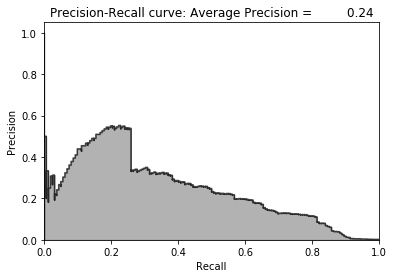

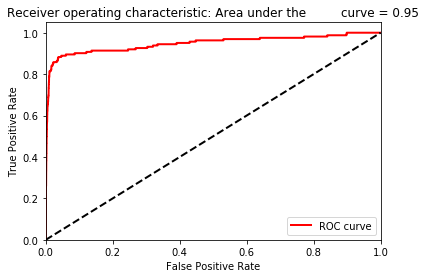

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.6682 - accuracy: 0.6389 - val_loss: 0.6171 - val_accuracy: 0.7215
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5858 - accuracy: 0.7879 - val_loss: 0.5736 - val_accuracy: 0.8159
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5793 - accuracy: 0.8121 - val_loss: 0.5668 - val_accuracy: 0.8454
Epoch 4/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5713 - accuracy: 0.8235 - val_loss: 0.5665 - val_accuracy: 0.8323
Epoch 5/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5649 - accuracy: 0.8377 - val_loss: 0.5595 - val_accuracy: 0.8485
Epoch 6/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.5630 - accuracy: 0.8407 - val_loss: 0.5592 - val_accuracy: 0.8638
Epoch 7/10
190820/190820 [================

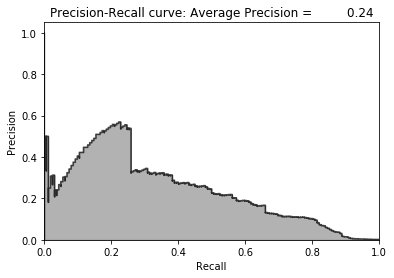

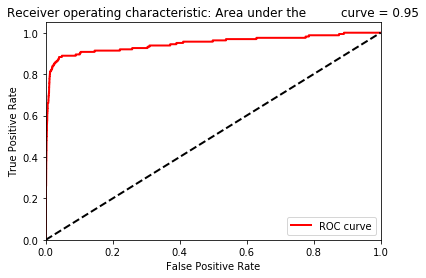

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.6795 - accuracy: 0.5946 - val_loss: 0.6170 - val_accuracy: 0.7126
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.6064 - accuracy: 0.7666 - val_loss: 0.5972 - val_accuracy: 0.7980
Epoch 3/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5979 - accuracy: 0.7915 - val_loss: 0.5934 - val_accuracy: 0.8086
Epoch 4/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5944 - accuracy: 0.8050 - val_loss: 0.5982 - val_accuracy: 0.7932
Epoch 5/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5937 - accuracy: 0.8110 - val_loss: 0.5904 - val_accuracy: 0.8211
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6065 - accuracy: 0.7779 - val_loss: 0.5888 - val_accuracy: 0.8338
Epoch 7/10
190820/190820 [================

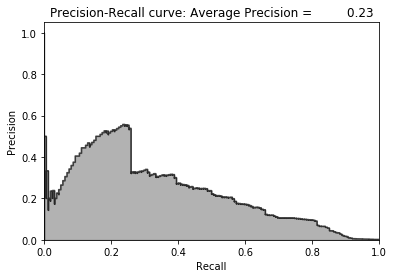

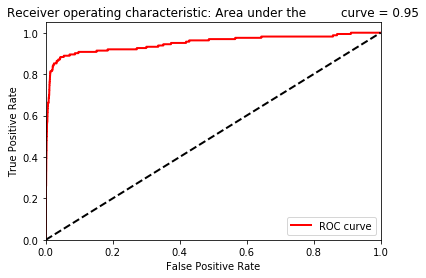

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.6724 - accuracy: 0.6392 - val_loss: 0.6092 - val_accuracy: 0.7226
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5855 - accuracy: 0.8309 - val_loss: 0.5711 - val_accuracy: 0.8782
Epoch 3/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5715 - accuracy: 0.8699 - val_loss: 0.5660 - val_accuracy: 0.8966
Epoch 4/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.5716 - accuracy: 0.8698 - val_loss: 0.5746 - val_accuracy: 0.8654
Epoch 5/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5701 - accuracy: 0.8733 - val_loss: 0.5628 - val_accuracy: 0.8958
Epoch 6/10
190820/190820 [==============================] - 8s 44us/sample - loss: 0.5660 - accuracy: 0.8859 - val_loss: 0.5618 - val_accuracy: 0.9030
Epoch 7/10
190820/190820 [================

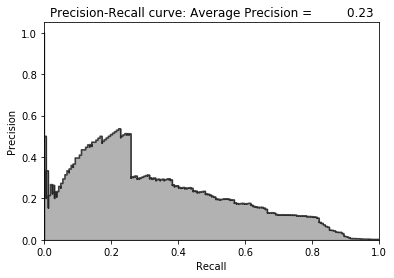

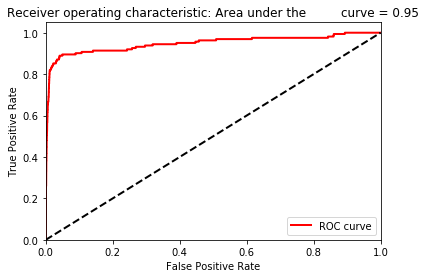

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.6776 - accuracy: 0.6107 - val_loss: 0.6249 - val_accuracy: 0.7180
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.6130 - accuracy: 0.7629 - val_loss: 0.6020 - val_accuracy: 0.8063
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.6043 - accuracy: 0.8018 - val_loss: 0.5973 - val_accuracy: 0.8286
Epoch 4/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5998 - accuracy: 0.8114 - val_loss: 0.5991 - val_accuracy: 0.8050
Epoch 5/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5961 - accuracy: 0.8152 - val_loss: 0.5894 - val_accuracy: 0.8418
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5926 - accuracy: 0.8210 - val_loss: 0.5892 - val_accuracy: 0.8408
Epoch 7/10
190820/190820 [================

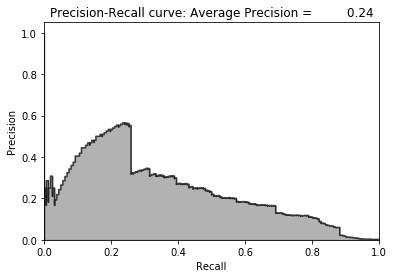

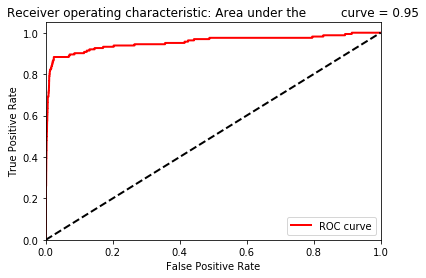

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6827 - accuracy: 0.6321 - val_loss: 0.6229 - val_accuracy: 0.7443
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.6007 - accuracy: 0.8171 - val_loss: 0.5951 - val_accuracy: 0.8454
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5944 - accuracy: 0.8388 - val_loss: 0.5910 - val_accuracy: 0.8613
Epoch 4/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5933 - accuracy: 0.8443 - val_loss: 0.5954 - val_accuracy: 0.8411
Epoch 5/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.5929 - accuracy: 0.8479 - val_loss: 0.5898 - val_accuracy: 0.8669
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5925 - accuracy: 0.8485 - val_loss: 0.5899 - val_accuracy: 0.8706
Epoch 7/10
190820/190820 [================

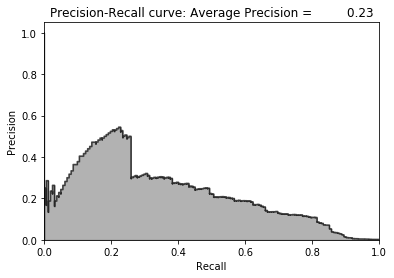

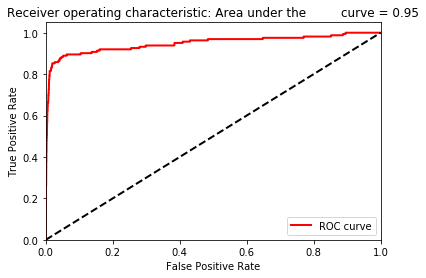

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6950 - accuracy: 0.5998 - val_loss: 0.6234 - val_accuracy: 0.7300
Epoch 2/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.6137 - accuracy: 0.7577 - val_loss: 0.6062 - val_accuracy: 0.7921
Epoch 3/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6084 - accuracy: 0.7799 - val_loss: 0.6033 - val_accuracy: 0.8051
Epoch 4/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6039 - accuracy: 0.7960 - val_loss: 0.6001 - val_accuracy: 0.8147
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5999 - accuracy: 0.8154 - val_loss: 0.5980 - val_accuracy: 0.8348
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6000 - accuracy: 0.8180 - val_loss: 0.5978 - val_accuracy: 0.8353
Epoch 7/10
190820/190820 [================

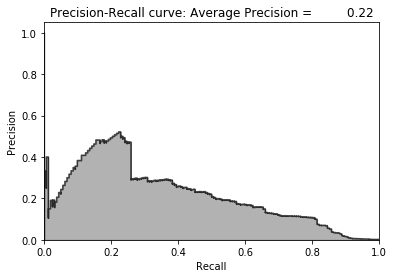

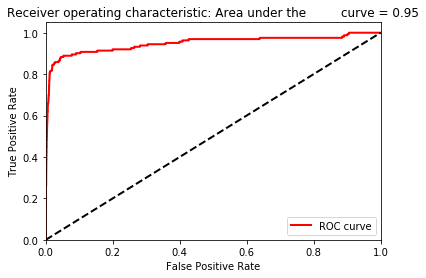

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.6643 - accuracy: 0.6421 - val_loss: 0.5977 - val_accuracy: 0.7448
Epoch 2/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5781 - accuracy: 0.8201 - val_loss: 0.5674 - val_accuracy: 0.8370
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.5668 - accuracy: 0.8442 - val_loss: 0.5608 - val_accuracy: 0.8632
Epoch 4/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5622 - accuracy: 0.8561 - val_loss: 0.5630 - val_accuracy: 0.8614
Epoch 5/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.5612 - accuracy: 0.8597 - val_loss: 0.5557 - val_accuracy: 0.8804
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5630 - accuracy: 0.8660 - val_loss: 0.5538 - val_accuracy: 0.8926
Epoch 7/10
190820/190820 [================

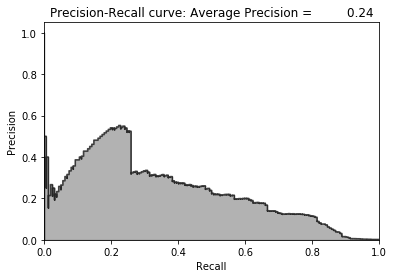

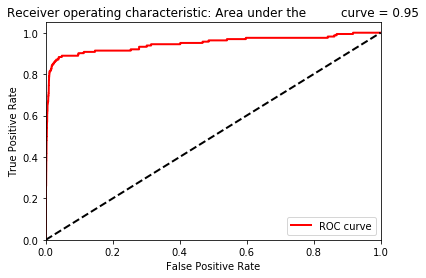

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 42us/sample - loss: 0.6743 - accuracy: 0.6316 - val_loss: 0.6263 - val_accuracy: 0.7043
Epoch 2/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.6041 - accuracy: 0.7611 - val_loss: 0.5933 - val_accuracy: 0.7901
Epoch 3/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5924 - accuracy: 0.7880 - val_loss: 0.5846 - val_accuracy: 0.8156
Epoch 4/10
190820/190820 [==============================] - 8s 41us/sample - loss: 0.5878 - accuracy: 0.7977 - val_loss: 0.5905 - val_accuracy: 0.7943
Epoch 5/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.5860 - accuracy: 0.8036 - val_loss: 0.5824 - val_accuracy: 0.8212
Epoch 6/10
190820/190820 [==============================] - 8s 42us/sample - loss: 0.5872 - accuracy: 0.8009 - val_loss: 0.5822 - val_accuracy: 0.8174
Epoch 7/10
190820/190820 [================

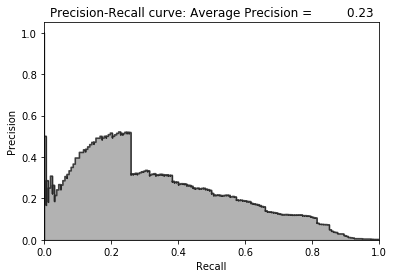

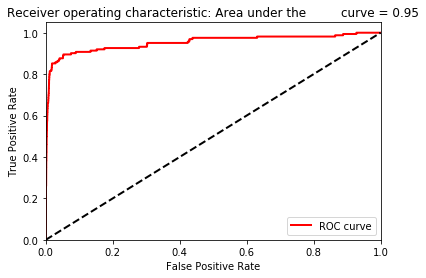

Mean average precision over 10 runs: 0.2312


[0.2204,
 0.2439,
 0.2396,
 0.2308,
 0.2262,
 0.2367,
 0.2265,
 0.2172,
 0.2373,
 0.2332]

In [30]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [31]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2312
Coefficient of variation over 10 runs: 0.0353


[0.2204,
 0.2439,
 0.2396,
 0.2308,
 0.2262,
 0.2367,
 0.2265,
 0.2172,
 0.2373,
 0.2332]

## Model Five
#### Two layer overcomplete autoencoder with linear activation
29 -> 40 -> 29

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0401 - accuracy: 0.9430 - val_loss: 0.0105 - val_accuracy: 0.9606
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0013 - accuracy: 0.9922 - val_loss: 1.5687e-06 - val_accuracy: 0.9995
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.4838e-04 - accuracy: 0.9945 - val_loss: 2.8381e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.3455e-04 - accuracy: 0.9933 - val_loss: 2.8951e-05 - val_accuracy: 0.9978
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0011 - accuracy: 0.9931 - val_loss: 0.0034 - val_accuracy: 0.9938
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.7065e-04 - accuracy: 0.9942 - val_loss: 8.8075e-04 - val_accuracy: 0.9896
Epoch 7/10
190

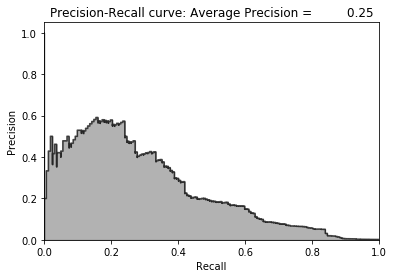

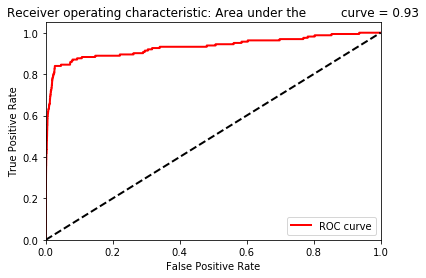

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0416 - accuracy: 0.9439 - val_loss: 0.0074 - val_accuracy: 0.9716
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0014 - accuracy: 0.9914 - val_loss: 3.2059e-06 - val_accuracy: 0.9991
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.5648e-04 - accuracy: 0.9947 - val_loss: 2.7872e-07 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.9468e-04 - accuracy: 0.9938 - val_loss: 3.0930e-05 - val_accuracy: 0.9980
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.8964e-04 - accuracy: 0.9931 - val_loss: 0.0019 - val_accuracy: 0.9960
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.2377e-04 - accuracy: 0.9945 - val_loss: 3.9102e-04 - val_accuracy: 0.9940
Epoch 7/10

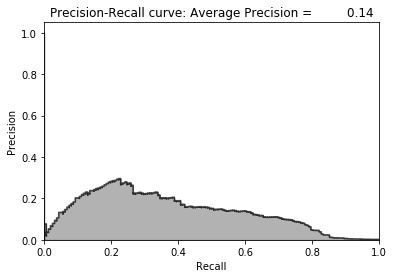

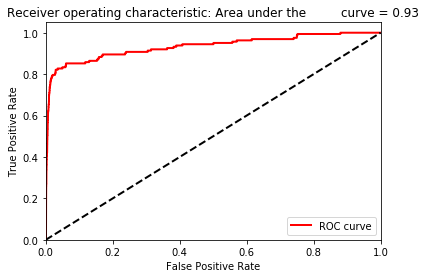

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0390 - accuracy: 0.9419 - val_loss: 0.0166 - val_accuracy: 0.9471
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0012 - accuracy: 0.9932 - val_loss: 3.3596e-07 - val_accuracy: 0.9996
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.0585e-04 - accuracy: 0.9946 - val_loss: 1.7043e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.3870e-04 - accuracy: 0.9926 - val_loss: 2.7165e-04 - val_accuracy: 0.9928
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0011 - accuracy: 0.9938 - val_loss: 0.0023 - val_accuracy: 0.9959
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.2259e-04 - accuracy: 0.9937 - val_loss: 6.9597e-04 - val_accuracy: 0.9903
Epoch 7/10
190

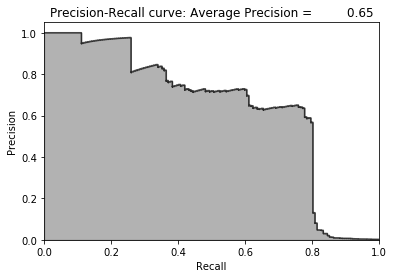

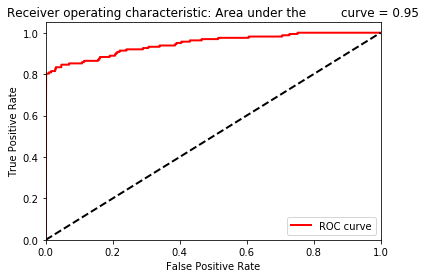

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0434 - accuracy: 0.9429 - val_loss: 0.0012 - val_accuracy: 0.9884
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0010 - accuracy: 0.9920 - val_loss: 1.5686e-05 - val_accuracy: 0.9986
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.1292e-04 - accuracy: 0.9936 - val_loss: 1.7465e-08 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.5916e-04 - accuracy: 0.9931 - val_loss: 7.5474e-05 - val_accuracy: 0.9961
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.1061e-04 - accuracy: 0.9933 - val_loss: 0.0035 - val_accuracy: 0.9953
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.4103e-04 - accuracy: 0.9928 - val_loss: 1.4768e-04 - val_accuracy: 0.9974
Epoch 7/10

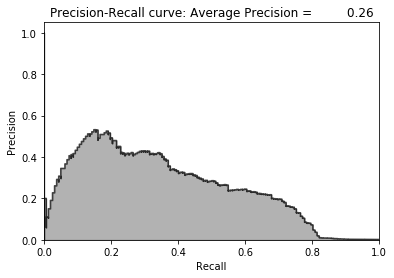

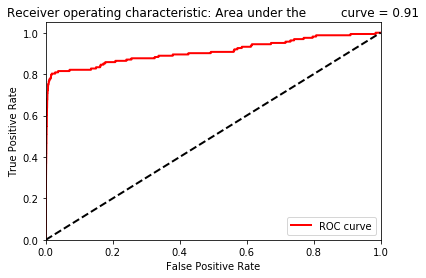

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0438 - accuracy: 0.9359 - val_loss: 0.0047 - val_accuracy: 0.9766
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0014 - accuracy: 0.9917 - val_loss: 3.2460e-07 - val_accuracy: 0.9996
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.1551e-04 - accuracy: 0.9941 - val_loss: 1.3127e-07 - val_accuracy: 0.9998
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.3654e-04 - accuracy: 0.9931 - val_loss: 3.5728e-05 - val_accuracy: 0.9974
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.6039e-04 - accuracy: 0.9932 - val_loss: 0.0015 - val_accuracy: 0.9954
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 6.9335e-04 - accuracy: 0.9930 - val_loss: 2.7522e-04 - val_accuracy: 0.9934
Epoch 7/10

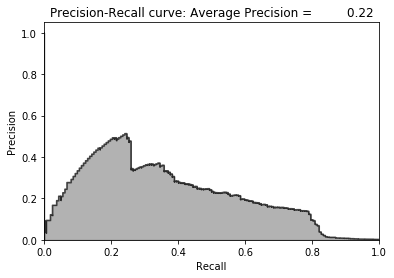

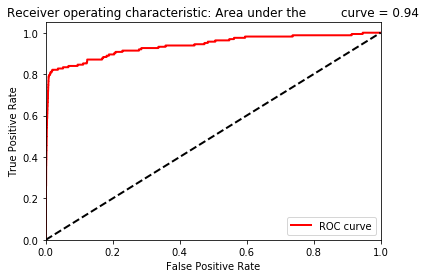

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0437 - accuracy: 0.9402 - val_loss: 0.0157 - val_accuracy: 0.9473
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0015 - accuracy: 0.9912 - val_loss: 1.4348e-06 - val_accuracy: 0.9995
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.6003e-04 - accuracy: 0.9947 - val_loss: 1.6254e-07 - val_accuracy: 0.9997
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 9.5037e-04 - accuracy: 0.9930 - val_loss: 1.8622e-05 - val_accuracy: 0.9983
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.2464e-04 - accuracy: 0.9932 - val_loss: 0.0038 - val_accuracy: 0.9949
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.5480e-04 - accuracy: 0.9938 - val_loss: 4.8355e-04 - val_accuracy: 0.9881
Epoch 7/10

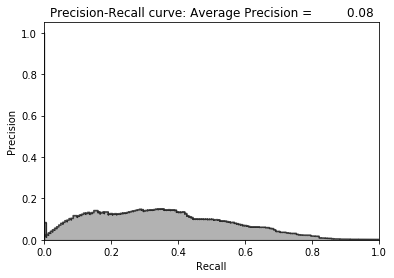

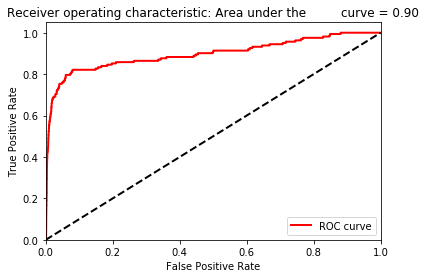

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0435 - accuracy: 0.9382 - val_loss: 1.5886e-04 - val_accuracy: 0.9945
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0011 - accuracy: 0.9917 - val_loss: 6.8019e-08 - val_accuracy: 0.9998
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.5897e-04 - accuracy: 0.9935 - val_loss: 1.8185e-08 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.4418e-04 - accuracy: 0.9924 - val_loss: 1.0098e-05 - val_accuracy: 0.9984
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.6123e-04 - accuracy: 0.9940 - val_loss: 2.2933e-04 - val_accuracy: 0.9972
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.3507e-04 - accuracy: 0.9937 - val_loss: 7.3415e-04 - val_accuracy: 0.9883
Ep

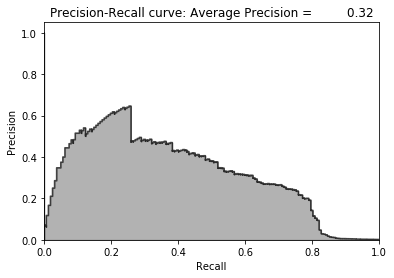

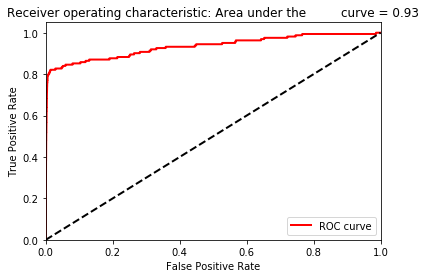

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0396 - accuracy: 0.9484 - val_loss: 0.0045 - val_accuracy: 0.9749
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 9.2247e-04 - accuracy: 0.9913 - val_loss: 5.0390e-06 - val_accuracy: 0.9989
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.2084e-04 - accuracy: 0.9938 - val_loss: 1.5395e-07 - val_accuracy: 0.9999
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.6608e-04 - accuracy: 0.9930 - val_loss: 2.1851e-05 - val_accuracy: 0.9981
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.5241e-04 - accuracy: 0.9940 - val_loss: 2.5140e-04 - val_accuracy: 0.9975
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 7.2972e-04 - accuracy: 0.9937 - val_loss: 1.4533e-04 - val_accuracy: 0.9956
Ep

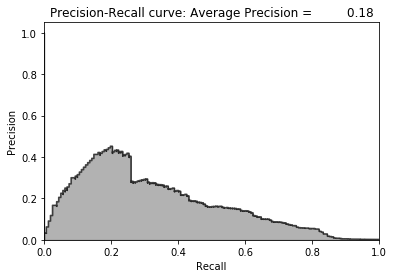

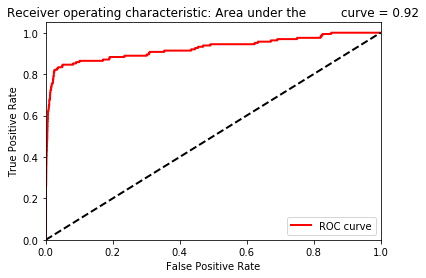

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0404 - accuracy: 0.9383 - val_loss: 0.0028 - val_accuracy: 0.9801
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0016 - accuracy: 0.9911 - val_loss: 2.2828e-06 - val_accuracy: 0.9994
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.5887e-04 - accuracy: 0.9946 - val_loss: 1.0559e-06 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 8.3110e-04 - accuracy: 0.9930 - val_loss: 2.0723e-05 - val_accuracy: 0.9982
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 8.3161e-04 - accuracy: 0.9932 - val_loss: 3.6858e-04 - val_accuracy: 0.9967
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.1712e-04 - accuracy: 0.9936 - val_loss: 6.1828e-04 - val_accuracy: 0.9911
Epoch 

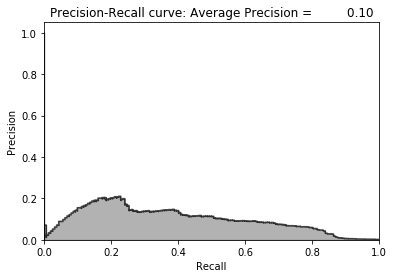

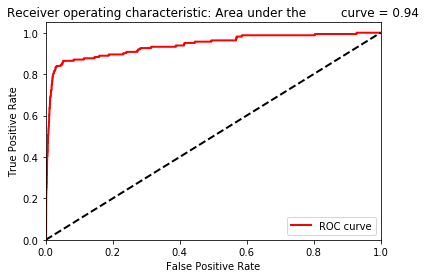

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0414 - accuracy: 0.9446 - val_loss: 0.0025 - val_accuracy: 0.9828
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0016 - accuracy: 0.9917 - val_loss: 7.4825e-07 - val_accuracy: 0.9996
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.3773e-04 - accuracy: 0.9949 - val_loss: 1.1980e-06 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 7.3085e-04 - accuracy: 0.9936 - val_loss: 7.4205e-05 - val_accuracy: 0.9964
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 9.1949e-04 - accuracy: 0.9928 - val_loss: 0.0023 - val_accuracy: 0.9953
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 6.4688e-04 - accuracy: 0.9932 - val_loss: 7.4235e-04 - val_accuracy: 0.9879
Epoch 7/10

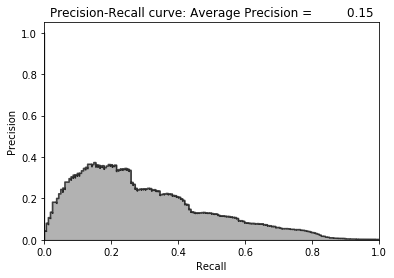

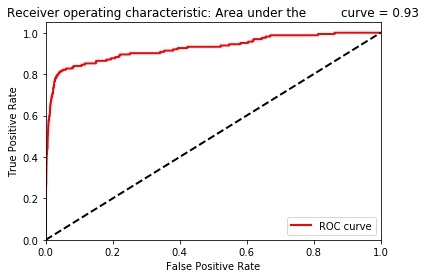

Mean average precision over 10 runs: 0.2339


[0.2469, 0.1376, 0.646, 0.2573, 0.2228, 0.0782, 0.3234, 0.1773, 0.0986, 0.1508]

In [33]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [34]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2339
Coefficient of variation over 10 runs: 0.6633


[0.2469, 0.1376, 0.646, 0.2573, 0.2228, 0.0782, 0.3234, 0.1773, 0.0986, 0.1508]

## Model Six
##### Two layer overcomplete autoencoder with linear activation and dropout
29 -> 40 -> 29  
Dropout percentage: 10%

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.1272 - accuracy: 0.7444 - val_loss: 0.0124 - val_accuracy: 0.9583
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0756 - accuracy: 0.7847 - val_loss: 0.0068 - val_accuracy: 0.9772
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0770 - accuracy: 0.7849 - val_loss: 0.0066 - val_accuracy: 0.9787
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0753 - accuracy: 0.7843 - val_loss: 0.0126 - val_accuracy: 0.9631
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0761 - accuracy: 0.7836 - val_loss: 0.0071 - val_accuracy: 0.9793
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0761 - accuracy: 0.7831 - val_loss: 0.0076 - val_accuracy: 0.9762
Epoch 7/10
190820/190820 [================

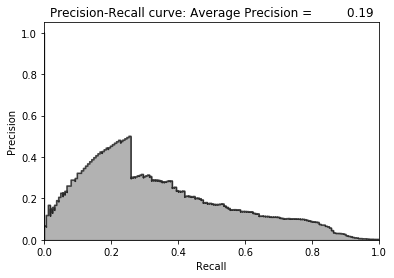

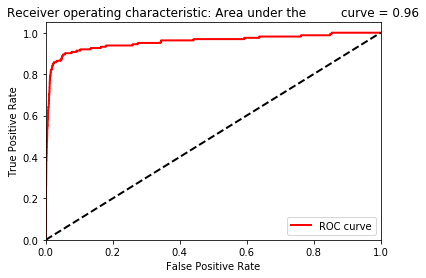

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1306 - accuracy: 0.7437 - val_loss: 0.0119 - val_accuracy: 0.9610
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0761 - accuracy: 0.7837 - val_loss: 0.0068 - val_accuracy: 0.9798
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0775 - accuracy: 0.7828 - val_loss: 0.0066 - val_accuracy: 0.9816
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0763 - accuracy: 0.7850 - val_loss: 0.0101 - val_accuracy: 0.9701
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0751 - accuracy: 0.7838 - val_loss: 0.0078 - val_accuracy: 0.9785
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0761 - accuracy: 0.7841 - val_loss: 0.0069 - val_accuracy: 0.9783
Epoch 7/10
190820/190820 [================

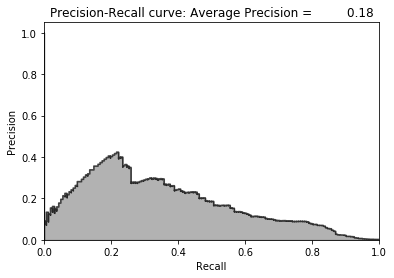

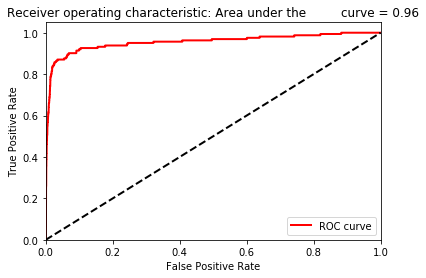

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1283 - accuracy: 0.7466 - val_loss: 0.0131 - val_accuracy: 0.9552
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0763 - accuracy: 0.7870 - val_loss: 0.0073 - val_accuracy: 0.9754
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0779 - accuracy: 0.7891 - val_loss: 0.0065 - val_accuracy: 0.9796
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0760 - accuracy: 0.7868 - val_loss: 0.0125 - val_accuracy: 0.9628
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0762 - accuracy: 0.7874 - val_loss: 0.0076 - val_accuracy: 0.9797
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0766 - accuracy: 0.7860 - val_loss: 0.0073 - val_accuracy: 0.9758
Epoch 7/10
190820/190820 [================

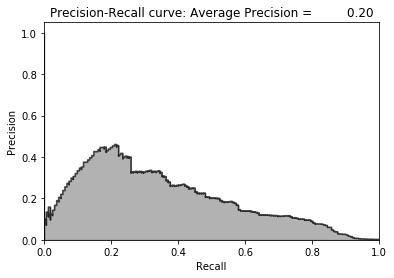

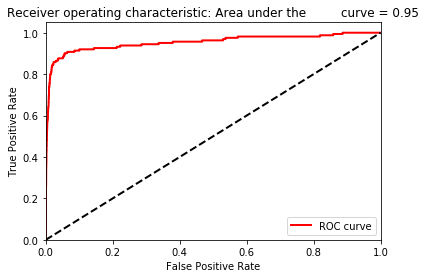

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1318 - accuracy: 0.7445 - val_loss: 0.0116 - val_accuracy: 0.9588
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0772 - accuracy: 0.7856 - val_loss: 0.0067 - val_accuracy: 0.9785
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0780 - accuracy: 0.7846 - val_loss: 0.0066 - val_accuracy: 0.9821
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0760 - accuracy: 0.7850 - val_loss: 0.0091 - val_accuracy: 0.9701
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0755 - accuracy: 0.7858 - val_loss: 0.0076 - val_accuracy: 0.9787
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0767 - accuracy: 0.7854 - val_loss: 0.0078 - val_accuracy: 0.9769
Epoch 7/10
190820/190820 [================

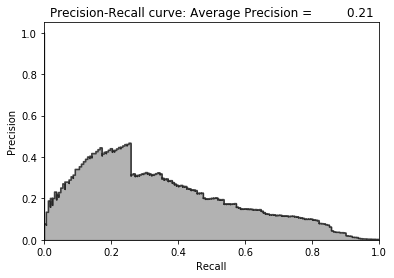

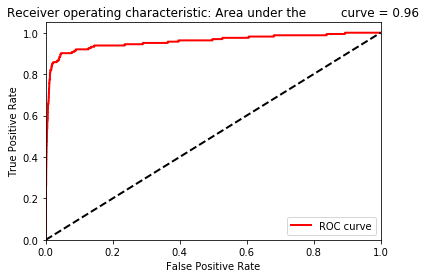

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1326 - accuracy: 0.7418 - val_loss: 0.0115 - val_accuracy: 0.9576
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0772 - accuracy: 0.7862 - val_loss: 0.0069 - val_accuracy: 0.9760
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0779 - accuracy: 0.7855 - val_loss: 0.0067 - val_accuracy: 0.9811
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0774 - accuracy: 0.7860 - val_loss: 0.0105 - val_accuracy: 0.9677
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0755 - accuracy: 0.7865 - val_loss: 0.0077 - val_accuracy: 0.9778
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0747 - accuracy: 0.7871 - val_loss: 0.0077 - val_accuracy: 0.9781
Epoch 7/10
190820/190820 [================

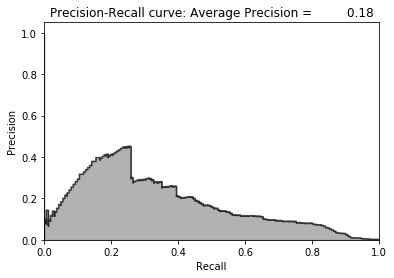

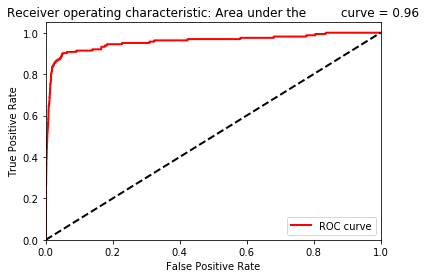

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1330 - accuracy: 0.7436 - val_loss: 0.0133 - val_accuracy: 0.9543
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0758 - accuracy: 0.7873 - val_loss: 0.0071 - val_accuracy: 0.9756
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0780 - accuracy: 0.7856 - val_loss: 0.0066 - val_accuracy: 0.9803
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0757 - accuracy: 0.7850 - val_loss: 0.0104 - val_accuracy: 0.9688
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0758 - accuracy: 0.7851 - val_loss: 0.0077 - val_accuracy: 0.9786
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0760 - accuracy: 0.7865 - val_loss: 0.0073 - val_accuracy: 0.9742
Epoch 7/10
190820/190820 [================

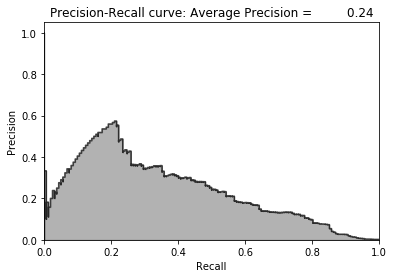

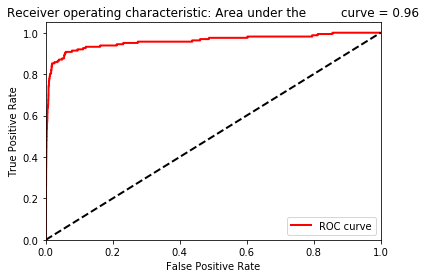

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1322 - accuracy: 0.7376 - val_loss: 0.0122 - val_accuracy: 0.9585
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0778 - accuracy: 0.7849 - val_loss: 0.0069 - val_accuracy: 0.9749
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0767 - accuracy: 0.7854 - val_loss: 0.0068 - val_accuracy: 0.9806
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0760 - accuracy: 0.7852 - val_loss: 0.0097 - val_accuracy: 0.9722
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0749 - accuracy: 0.7857 - val_loss: 0.0073 - val_accuracy: 0.9789
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0764 - accuracy: 0.7852 - val_loss: 0.0072 - val_accuracy: 0.9760
Epoch 7/10
190820/190820 [================

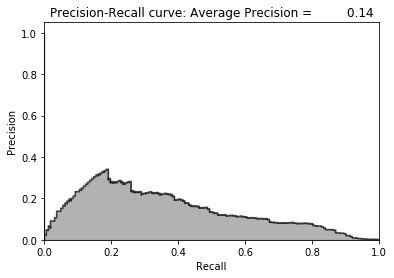

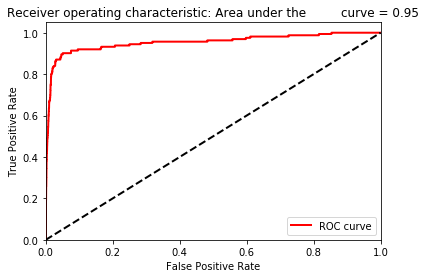

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1262 - accuracy: 0.7493 - val_loss: 0.0126 - val_accuracy: 0.9567
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0764 - accuracy: 0.7872 - val_loss: 0.0067 - val_accuracy: 0.9781
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0799 - accuracy: 0.7875 - val_loss: 0.0065 - val_accuracy: 0.9822
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0763 - accuracy: 0.7867 - val_loss: 0.0090 - val_accuracy: 0.9712
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0756 - accuracy: 0.7880 - val_loss: 0.0079 - val_accuracy: 0.9771
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0756 - accuracy: 0.7872 - val_loss: 0.0072 - val_accuracy: 0.9786
Epoch 7/10
190820/190820 [================

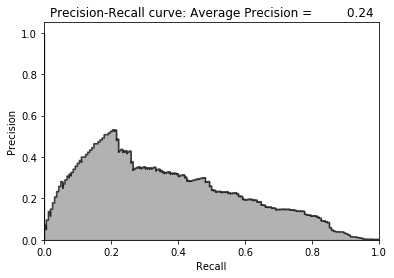

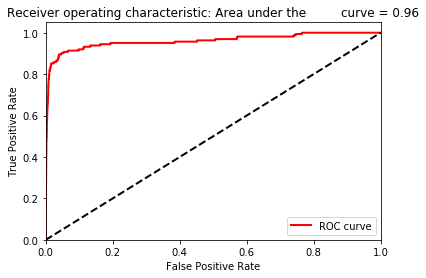

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1305 - accuracy: 0.7391 - val_loss: 0.0120 - val_accuracy: 0.9572
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0766 - accuracy: 0.7843 - val_loss: 0.0070 - val_accuracy: 0.9782
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0782 - accuracy: 0.7857 - val_loss: 0.0067 - val_accuracy: 0.9814
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0773 - accuracy: 0.7847 - val_loss: 0.0113 - val_accuracy: 0.9628
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0751 - accuracy: 0.7849 - val_loss: 0.0074 - val_accuracy: 0.9782
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0756 - accuracy: 0.7851 - val_loss: 0.0081 - val_accuracy: 0.9746
Epoch 7/10
190820/190820 [================

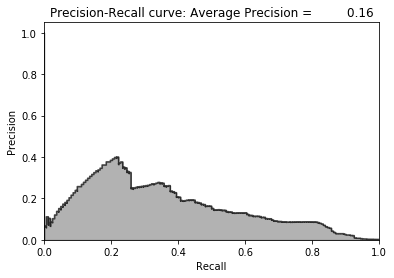

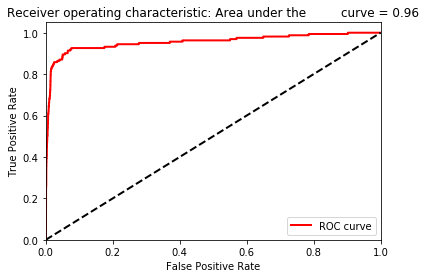

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1270 - accuracy: 0.7483 - val_loss: 0.0118 - val_accuracy: 0.9592
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0761 - accuracy: 0.7863 - val_loss: 0.0069 - val_accuracy: 0.9722
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0782 - accuracy: 0.7865 - val_loss: 0.0067 - val_accuracy: 0.9799
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0767 - accuracy: 0.7854 - val_loss: 0.0118 - val_accuracy: 0.9647
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0761 - accuracy: 0.7873 - val_loss: 0.0079 - val_accuracy: 0.9789
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0764 - accuracy: 0.7870 - val_loss: 0.0075 - val_accuracy: 0.9756
Epoch 7/10
190820/190820 [================

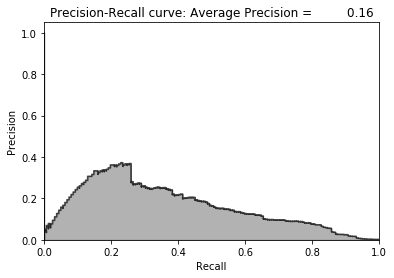

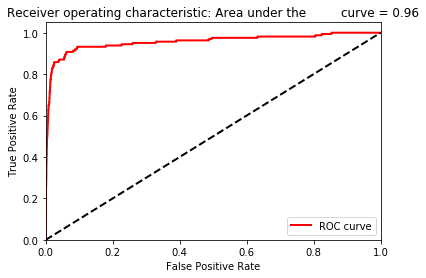

Mean average precision over 10 runs: 0.1905


[0.1933,
 0.1788,
 0.2026,
 0.2066,
 0.1778,
 0.2393,
 0.1438,
 0.2357,
 0.1634,
 0.1633]

In [36]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [37]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1905
Coefficient of variation over 10 runs: 0.1556


[0.1933,
 0.1788,
 0.2026,
 0.2066,
 0.1778,
 0.2393,
 0.1438,
 0.2357,
 0.1634,
 0.1633]

## Model Seven
#### Two layer sparse overcomplete autoencoder with linear activation
29 -> 40 -> 29

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0428 - accuracy: 0.9431 - val_loss: 0.0131 - val_accuracy: 0.9605
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0036 - accuracy: 0.9922 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9939 - val_loss: 0.0019 - val_accuracy: 0.9994
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9929 - val_loss: 0.0017 - val_accuracy: 0.9970
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9924 - val_loss: 0.0035 - val_accuracy: 0.9958
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0023 - accuracy: 0.9917 - val_loss: 0.0030 - val_accuracy: 0.9870
Epoch 7/10
190820/190820 [================

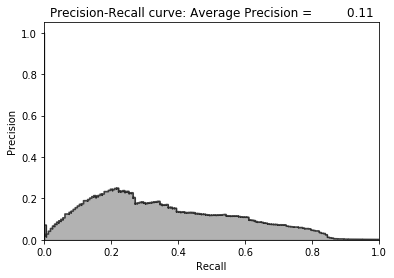

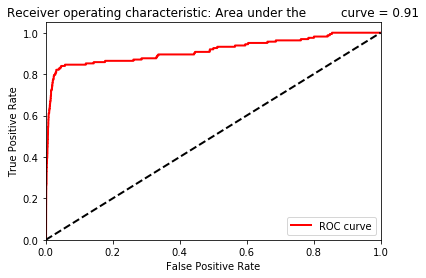

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0442 - accuracy: 0.9438 - val_loss: 0.0107 - val_accuracy: 0.9693
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0035 - accuracy: 0.9922 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0029 - accuracy: 0.9946 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0028 - accuracy: 0.9925 - val_loss: 0.0018 - val_accuracy: 0.9968
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9925 - val_loss: 0.0063 - val_accuracy: 0.9936
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0024 - accuracy: 0.9924 - val_loss: 0.0024 - val_accuracy: 0.9894
Epoch 7/10
190820/190820 [================

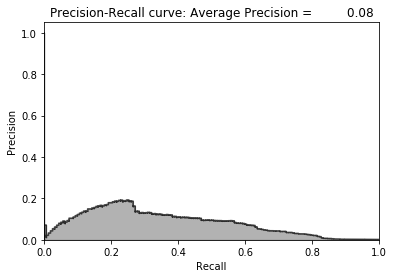

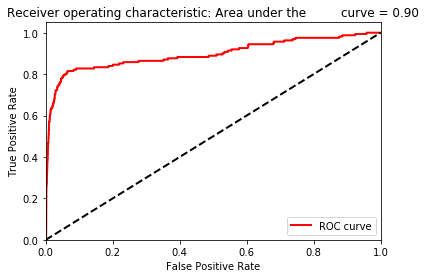

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0417 - accuracy: 0.9418 - val_loss: 0.0176 - val_accuracy: 0.9498
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0035 - accuracy: 0.9933 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9943 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0027 - accuracy: 0.9928 - val_loss: 0.0019 - val_accuracy: 0.9951
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9922 - val_loss: 0.0018 - val_accuracy: 0.9973
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0023 - accuracy: 0.9917 - val_loss: 0.0026 - val_accuracy: 0.9849
Epoch 7/10
190820/190820 [================

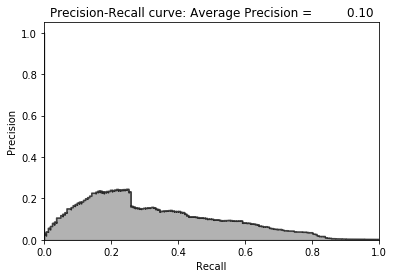

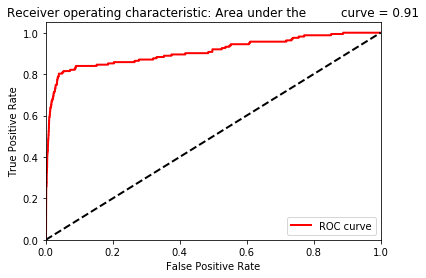

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0461 - accuracy: 0.9428 - val_loss: 0.0056 - val_accuracy: 0.9811
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0040 - accuracy: 0.9911 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9945 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9923 - val_loss: 0.0018 - val_accuracy: 0.9956
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0027 - accuracy: 0.9929 - val_loss: 0.0051 - val_accuracy: 0.9950
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0024 - accuracy: 0.9921 - val_loss: 0.0019 - val_accuracy: 0.9934
Epoch 7/10
190820/190820 [================

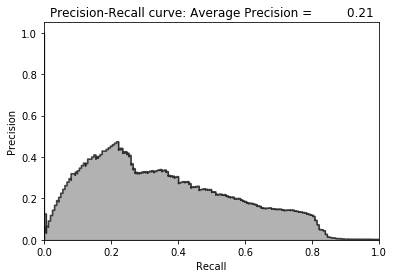

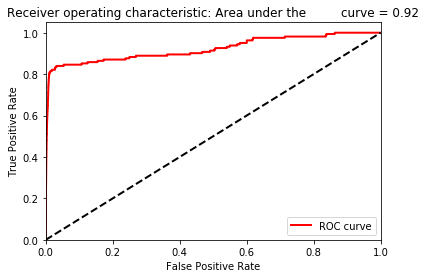

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0465 - accuracy: 0.9359 - val_loss: 0.0055 - val_accuracy: 0.9801
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0038 - accuracy: 0.9919 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9941 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9924 - val_loss: 0.0017 - val_accuracy: 0.9973
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9927 - val_loss: 0.0040 - val_accuracy: 0.9950
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0023 - accuracy: 0.9922 - val_loss: 0.0024 - val_accuracy: 0.9887
Epoch 7/10
190820/190820 [================

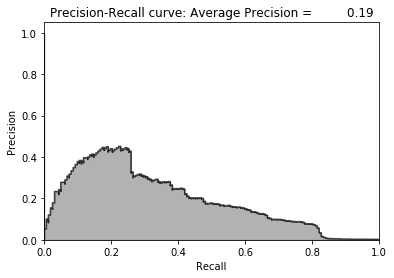

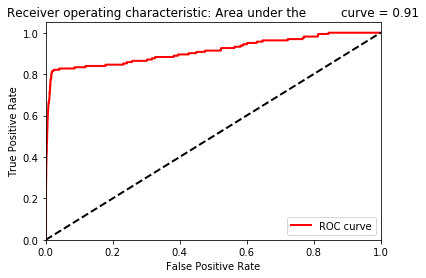

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0463 - accuracy: 0.9402 - val_loss: 0.0045 - val_accuracy: 0.9820
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0039 - accuracy: 0.9915 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9944 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9919 - val_loss: 0.0017 - val_accuracy: 0.9980
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0026 - accuracy: 0.9924 - val_loss: 0.0046 - val_accuracy: 0.9950
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0024 - accuracy: 0.9923 - val_loss: 0.0028 - val_accuracy: 0.9857
Epoch 7/10
190820/190820 [================

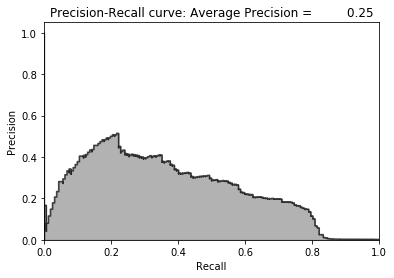

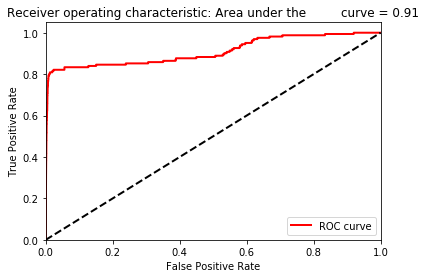

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0461 - accuracy: 0.9383 - val_loss: 0.0032 - val_accuracy: 0.9906
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0037 - accuracy: 0.9913 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 3/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0028 - accuracy: 0.9942 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9922 - val_loss: 0.0017 - val_accuracy: 0.9972
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0030 - accuracy: 0.9925 - val_loss: 0.0023 - val_accuracy: 0.9960
Epoch 6/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0024 - accuracy: 0.9914 - val_loss: 0.0023 - val_accuracy: 0.9887
Epoch 7/10
190820/190820 [================

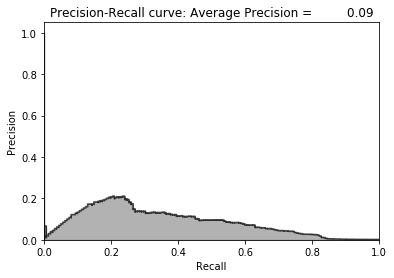

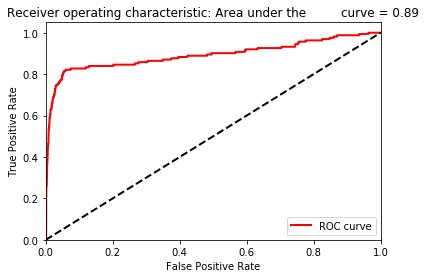

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0423 - accuracy: 0.9482 - val_loss: 0.0053 - val_accuracy: 0.9800
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0038 - accuracy: 0.9918 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9943 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0028 - accuracy: 0.9922 - val_loss: 0.0018 - val_accuracy: 0.9962
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0028 - accuracy: 0.9929 - val_loss: 0.0055 - val_accuracy: 0.9948
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0024 - accuracy: 0.9926 - val_loss: 0.0024 - val_accuracy: 0.9858
Epoch 7/10
190820/190820 [================

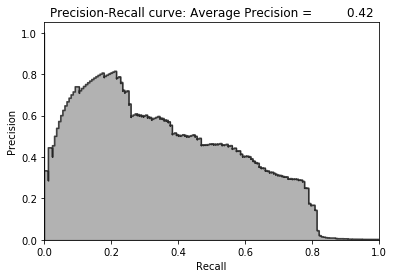

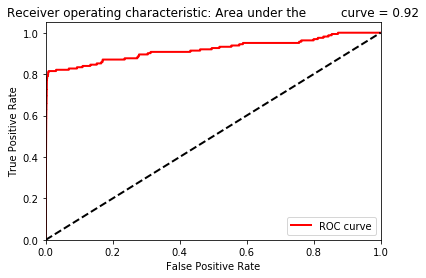

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0432 - accuracy: 0.9384 - val_loss: 0.0054 - val_accuracy: 0.9808
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0040 - accuracy: 0.9917 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0029 - accuracy: 0.9949 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0029 - accuracy: 0.9918 - val_loss: 0.0018 - val_accuracy: 0.9979
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0028 - accuracy: 0.9929 - val_loss: 0.0046 - val_accuracy: 0.9946
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0024 - accuracy: 0.9917 - val_loss: 0.0026 - val_accuracy: 0.9889
Epoch 7/10
190820/190820 [================

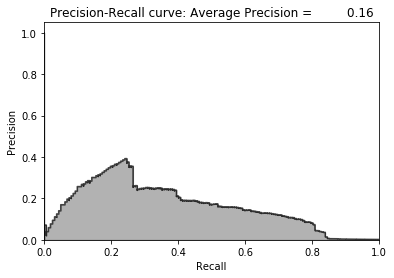

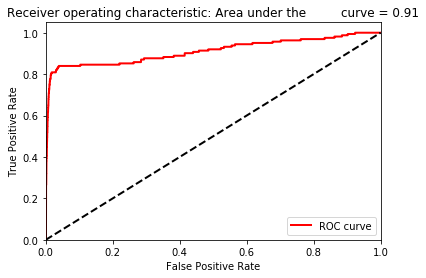

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0440 - accuracy: 0.9445 - val_loss: 0.0050 - val_accuracy: 0.9828
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0039 - accuracy: 0.9917 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0029 - accuracy: 0.9949 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9928 - val_loss: 0.0019 - val_accuracy: 0.9944
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0027 - accuracy: 0.9927 - val_loss: 0.0022 - val_accuracy: 0.9964
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0024 - accuracy: 0.9921 - val_loss: 0.0028 - val_accuracy: 0.9835
Epoch 7/10
190820/190820 [================

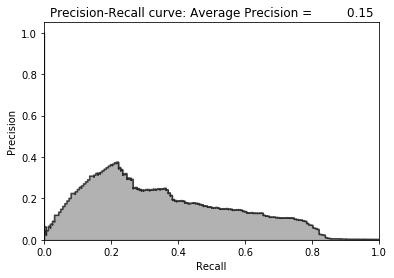

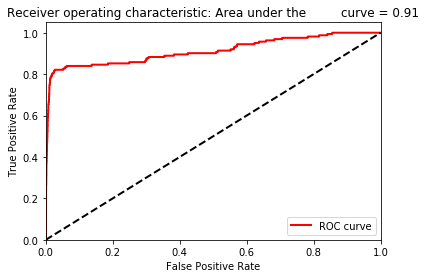

Mean average precision over 10 runs: 0.1775


[0.1109,
 0.0817,
 0.1001,
 0.2139,
 0.1928,
 0.2504,
 0.0864,
 0.4207,
 0.1628,
 0.1549]

In [39]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [40]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1775
Coefficient of variation over 10 runs: 0.5483


[0.1109,
 0.0817,
 0.1001,
 0.2139,
 0.1928,
 0.2504,
 0.0864,
 0.4207,
 0.1628,
 0.1549]

## Model Eight
##### Two layer sparse overcomplete autoencoder with linear activation and dropout
29 -> 40 -> 29  
Dropout percentage: 5%

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0892 - accuracy: 0.8151 - val_loss: 0.0099 - val_accuracy: 0.9676
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0416 - accuracy: 0.8611 - val_loss: 0.0043 - val_accuracy: 0.9851
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0409 - accuracy: 0.8602 - val_loss: 0.0041 - val_accuracy: 0.9845
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0406 - accuracy: 0.8606 - val_loss: 0.0091 - val_accuracy: 0.9716
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0411 - accuracy: 0.8608 - val_loss: 0.0051 - val_accuracy: 0.9838
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0406 - accuracy: 0.8601 - val_loss: 0.0058 - val_accuracy: 0.9806
Epoch 7/10
190820/190820 [================

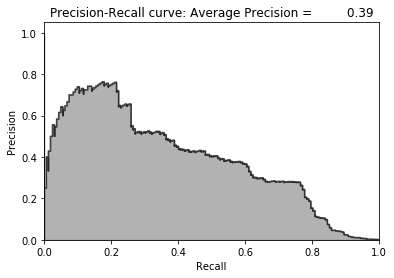

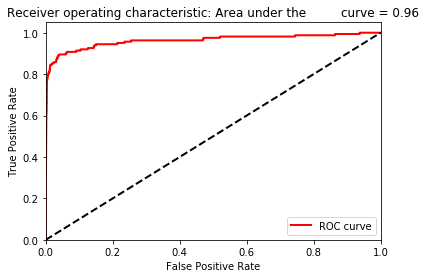

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0902 - accuracy: 0.8175 - val_loss: 0.0094 - val_accuracy: 0.9697
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0423 - accuracy: 0.8605 - val_loss: 0.0042 - val_accuracy: 0.9846
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0415 - accuracy: 0.8610 - val_loss: 0.0041 - val_accuracy: 0.9843
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0405 - accuracy: 0.8606 - val_loss: 0.0081 - val_accuracy: 0.9741
Epoch 5/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0412 - accuracy: 0.8613 - val_loss: 0.0050 - val_accuracy: 0.9838
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0408 - accuracy: 0.8606 - val_loss: 0.0059 - val_accuracy: 0.9803
Epoch 7/10
190820/190820 [================

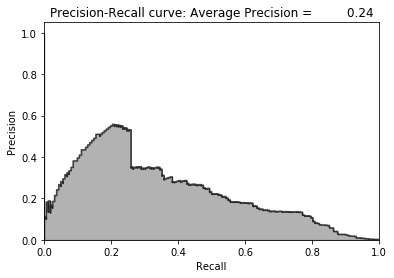

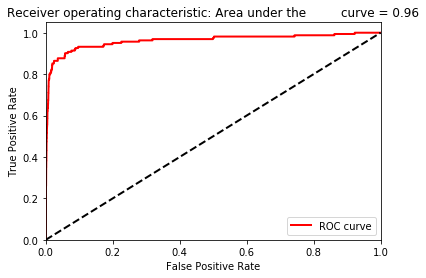

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0880 - accuracy: 0.8174 - val_loss: 0.0081 - val_accuracy: 0.9699
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0429 - accuracy: 0.8613 - val_loss: 0.0043 - val_accuracy: 0.9837
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0416 - accuracy: 0.8620 - val_loss: 0.0041 - val_accuracy: 0.9841
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0400 - accuracy: 0.8634 - val_loss: 0.0094 - val_accuracy: 0.9682
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0409 - accuracy: 0.8625 - val_loss: 0.0049 - val_accuracy: 0.9848
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0404 - accuracy: 0.8632 - val_loss: 0.0046 - val_accuracy: 0.9815
Epoch 7/10
190820/190820 [================

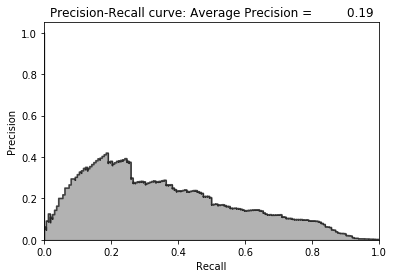

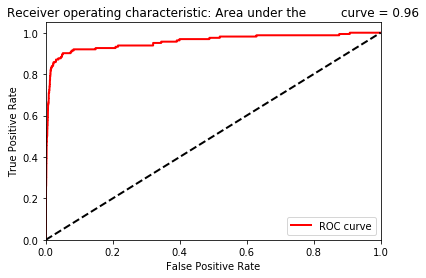

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0929 - accuracy: 0.8147 - val_loss: 0.0096 - val_accuracy: 0.9648
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0413 - accuracy: 0.8615 - val_loss: 0.0044 - val_accuracy: 0.9803
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0421 - accuracy: 0.8610 - val_loss: 0.0041 - val_accuracy: 0.9842
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0403 - accuracy: 0.8617 - val_loss: 0.0102 - val_accuracy: 0.9655
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0403 - accuracy: 0.8624 - val_loss: 0.0043 - val_accuracy: 0.9861
Epoch 6/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0406 - accuracy: 0.8608 - val_loss: 0.0049 - val_accuracy: 0.9794
Epoch 7/10
190820/190820 [================

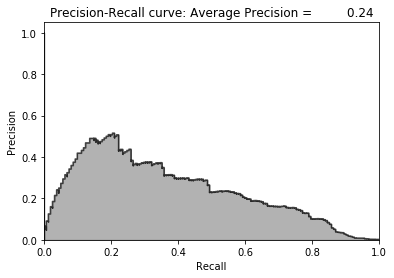

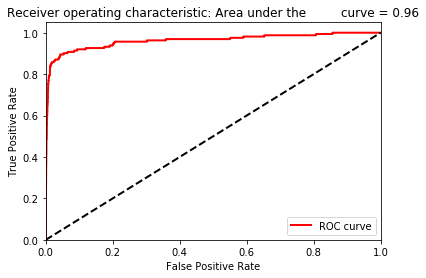

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0927 - accuracy: 0.8108 - val_loss: 0.0099 - val_accuracy: 0.9645
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0415 - accuracy: 0.8608 - val_loss: 0.0041 - val_accuracy: 0.9863
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0411 - accuracy: 0.8629 - val_loss: 0.0040 - val_accuracy: 0.9834
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0407 - accuracy: 0.8628 - val_loss: 0.0098 - val_accuracy: 0.9667
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0406 - accuracy: 0.8614 - val_loss: 0.0044 - val_accuracy: 0.9856
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0405 - accuracy: 0.8623 - val_loss: 0.0079 - val_accuracy: 0.9697
Epoch 7/10
190820/190820 [================

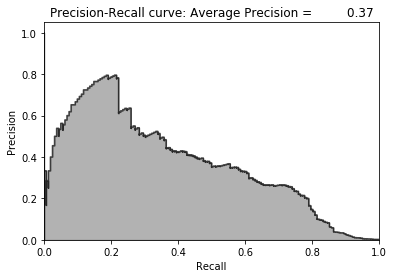

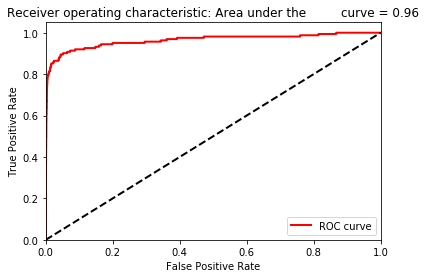

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0926 - accuracy: 0.8141 - val_loss: 0.0100 - val_accuracy: 0.9624
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0422 - accuracy: 0.8617 - val_loss: 0.0043 - val_accuracy: 0.9826
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0415 - accuracy: 0.8615 - val_loss: 0.0041 - val_accuracy: 0.9843
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0392 - accuracy: 0.8620 - val_loss: 0.0073 - val_accuracy: 0.9743
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0414 - accuracy: 0.8612 - val_loss: 0.0052 - val_accuracy: 0.9844
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0415 - accuracy: 0.8602 - val_loss: 0.0053 - val_accuracy: 0.9799
Epoch 7/10
190820/190820 [================

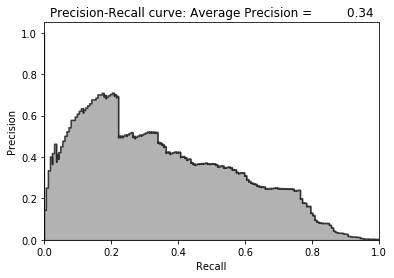

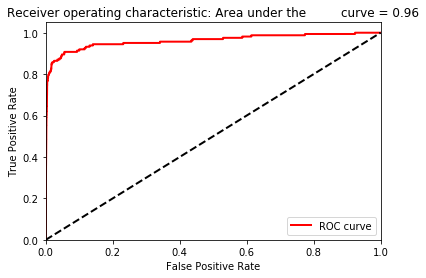

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0917 - accuracy: 0.8092 - val_loss: 0.0089 - val_accuracy: 0.9663
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0413 - accuracy: 0.8598 - val_loss: 0.0043 - val_accuracy: 0.9844
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0429 - accuracy: 0.8600 - val_loss: 0.0040 - val_accuracy: 0.9845
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0407 - accuracy: 0.8609 - val_loss: 0.0084 - val_accuracy: 0.9682
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0409 - accuracy: 0.8594 - val_loss: 0.0047 - val_accuracy: 0.9825
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0395 - accuracy: 0.8615 - val_loss: 0.0070 - val_accuracy: 0.9789
Epoch 7/10
190820/190820 [================

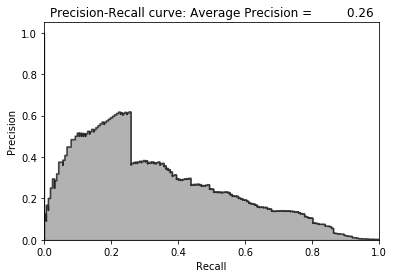

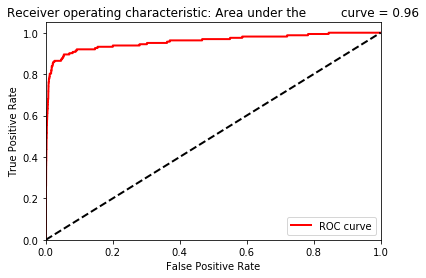

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0891 - accuracy: 0.8191 - val_loss: 0.0085 - val_accuracy: 0.9671
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0412 - accuracy: 0.8624 - val_loss: 0.0041 - val_accuracy: 0.9840
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0418 - accuracy: 0.8623 - val_loss: 0.0041 - val_accuracy: 0.9854
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0403 - accuracy: 0.8616 - val_loss: 0.0107 - val_accuracy: 0.9652
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0402 - accuracy: 0.8606 - val_loss: 0.0052 - val_accuracy: 0.9819
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0403 - accuracy: 0.8617 - val_loss: 0.0054 - val_accuracy: 0.9772
Epoch 7/10
190820/190820 [================

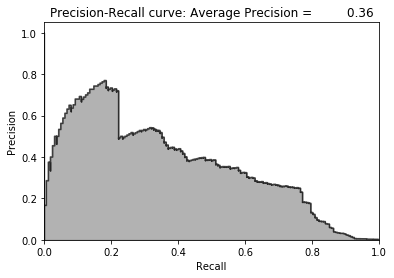

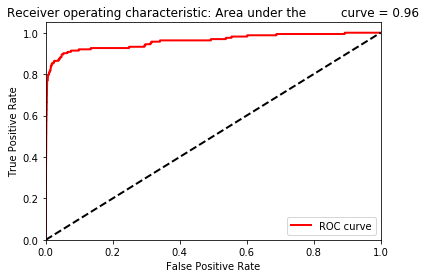

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.0900 - accuracy: 0.8120 - val_loss: 0.0095 - val_accuracy: 0.9663
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0423 - accuracy: 0.8610 - val_loss: 0.0042 - val_accuracy: 0.9859
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0416 - accuracy: 0.8610 - val_loss: 0.0042 - val_accuracy: 0.9848
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0398 - accuracy: 0.8625 - val_loss: 0.0092 - val_accuracy: 0.9690
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0412 - accuracy: 0.8616 - val_loss: 0.0045 - val_accuracy: 0.9861
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0411 - accuracy: 0.8603 - val_loss: 0.0051 - val_accuracy: 0.9790
Epoch 7/10
190820/190820 [================

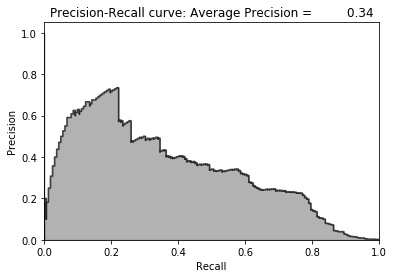

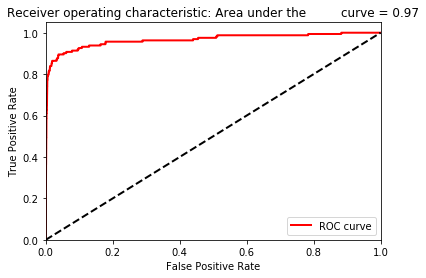

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.0896 - accuracy: 0.8177 - val_loss: 0.0087 - val_accuracy: 0.9689
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0418 - accuracy: 0.8617 - val_loss: 0.0042 - val_accuracy: 0.9847
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0410 - accuracy: 0.8623 - val_loss: 0.0041 - val_accuracy: 0.9839
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0402 - accuracy: 0.8646 - val_loss: 0.0083 - val_accuracy: 0.9720
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0405 - accuracy: 0.8620 - val_loss: 0.0048 - val_accuracy: 0.9852
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0396 - accuracy: 0.8621 - val_loss: 0.0043 - val_accuracy: 0.9838
Epoch 7/10
190820/190820 [================

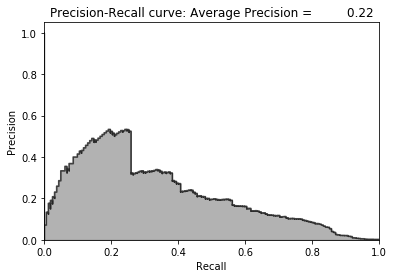

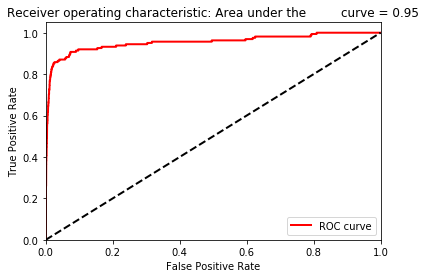

Mean average precision over 10 runs: 0.2957


[0.3906,
 0.2351,
 0.1865,
 0.2415,
 0.3723,
 0.3411,
 0.2608,
 0.3637,
 0.3429,
 0.2227]

In [42]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [43]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2957
Coefficient of variation over 10 runs: 0.2364


[0.3906,
 0.2351,
 0.1865,
 0.2415,
 0.3723,
 0.3411,
 0.2608,
 0.3637,
 0.3429,
 0.2227]

## Model Nine
##### Two layer denoising undercomplete autoencoder with linear activation
29 -> 27 -> 29

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1264 - accuracy: 0.8029 - val_loss: 0.0385 - val_accuracy: 0.8860
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0548 - accuracy: 0.8750 - val_loss: 0.0356 - val_accuracy: 0.9275
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0573 - accuracy: 0.8992 - val_loss: 0.0362 - val_accuracy: 0.9584
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0561 - accuracy: 0.9021 - val_loss: 0.0369 - val_accuracy: 0.9533
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0558 - accuracy: 0.9062 - val_loss: 0.0364 - val_accuracy: 0.9560
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0561 - accuracy: 0.9104 - val_loss: 0.0369 - val_accuracy: 0.9636
Epoch 7/10
190820/190820 [================

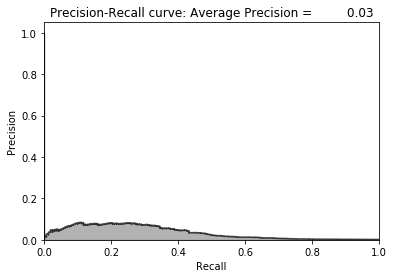

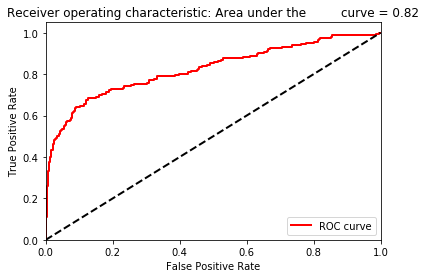

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1252 - accuracy: 0.7909 - val_loss: 0.0399 - val_accuracy: 0.8862
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0581 - accuracy: 0.8696 - val_loss: 0.0363 - val_accuracy: 0.9099
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0561 - accuracy: 0.8909 - val_loss: 0.0363 - val_accuracy: 0.9488
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0560 - accuracy: 0.8963 - val_loss: 0.0371 - val_accuracy: 0.9519
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.9089 - val_loss: 0.0366 - val_accuracy: 0.9500
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0562 - accuracy: 0.9123 - val_loss: 0.0370 - val_accuracy: 0.9636
Epoch 7/10
190820/190820 [================

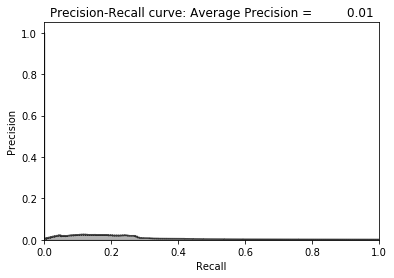

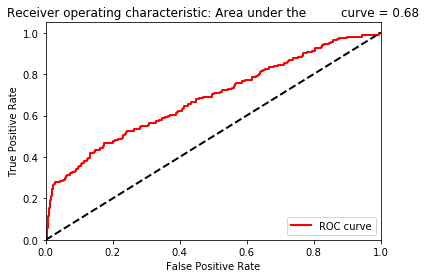

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1337 - accuracy: 0.8038 - val_loss: 0.0397 - val_accuracy: 0.9239
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0576 - accuracy: 0.8973 - val_loss: 0.0365 - val_accuracy: 0.9445
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0560 - accuracy: 0.9021 - val_loss: 0.0363 - val_accuracy: 0.9590
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.9036 - val_loss: 0.0372 - val_accuracy: 0.9575
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0558 - accuracy: 0.9125 - val_loss: 0.0366 - val_accuracy: 0.9564
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0562 - accuracy: 0.9120 - val_loss: 0.0368 - val_accuracy: 0.9676
Epoch 7/10
190820/190820 [================

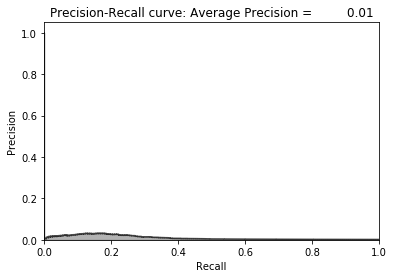

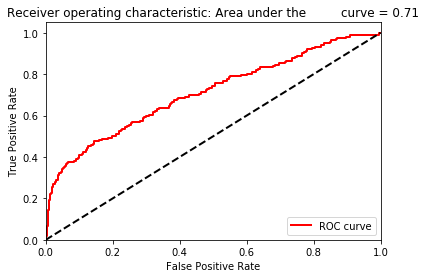

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1271 - accuracy: 0.7968 - val_loss: 0.0401 - val_accuracy: 0.9108
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0575 - accuracy: 0.9064 - val_loss: 0.0365 - val_accuracy: 0.9637
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0559 - accuracy: 0.9081 - val_loss: 0.0364 - val_accuracy: 0.9631
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0557 - accuracy: 0.9072 - val_loss: 0.0375 - val_accuracy: 0.9585
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0559 - accuracy: 0.9146 - val_loss: 0.0367 - val_accuracy: 0.9580
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0561 - accuracy: 0.9140 - val_loss: 0.0369 - val_accuracy: 0.9661
Epoch 7/10
190820/190820 [================

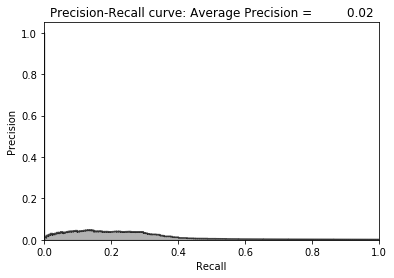

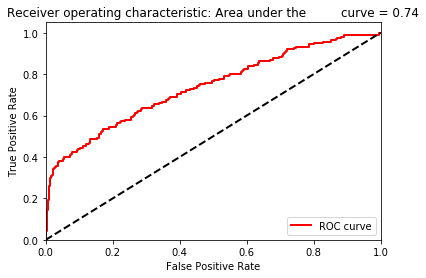

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1291 - accuracy: 0.7991 - val_loss: 0.0398 - val_accuracy: 0.9197
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0579 - accuracy: 0.8953 - val_loss: 0.0363 - val_accuracy: 0.9511
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0563 - accuracy: 0.9056 - val_loss: 0.0365 - val_accuracy: 0.9621
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0557 - accuracy: 0.9115 - val_loss: 0.0372 - val_accuracy: 0.9591
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0558 - accuracy: 0.9163 - val_loss: 0.0366 - val_accuracy: 0.9575
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0562 - accuracy: 0.9145 - val_loss: 0.0368 - val_accuracy: 0.9673
Epoch 7/10
190820/190820 [================

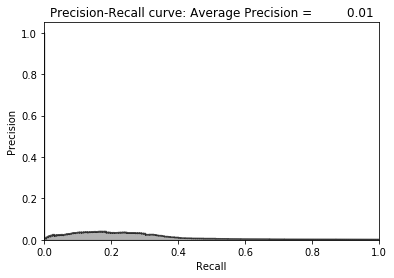

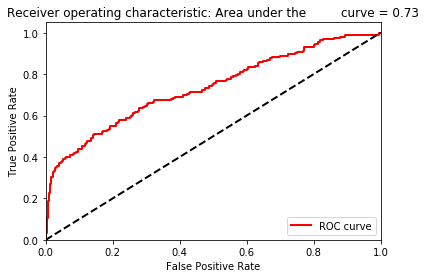

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1256 - accuracy: 0.7980 - val_loss: 0.0401 - val_accuracy: 0.9188
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0577 - accuracy: 0.8939 - val_loss: 0.0363 - val_accuracy: 0.9484
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0561 - accuracy: 0.9034 - val_loss: 0.0364 - val_accuracy: 0.9599
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0558 - accuracy: 0.9054 - val_loss: 0.0374 - val_accuracy: 0.9517
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0561 - accuracy: 0.9092 - val_loss: 0.0366 - val_accuracy: 0.9563
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0563 - accuracy: 0.9133 - val_loss: 0.0369 - val_accuracy: 0.9651
Epoch 7/10
190820/190820 [================

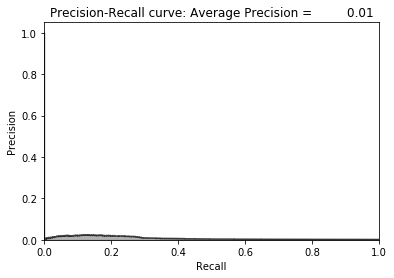

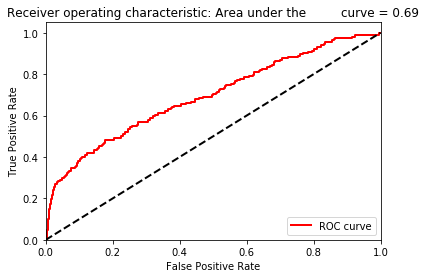

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1260 - accuracy: 0.7886 - val_loss: 0.0388 - val_accuracy: 0.8668
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0577 - accuracy: 0.8686 - val_loss: 0.0359 - val_accuracy: 0.9135
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0563 - accuracy: 0.8852 - val_loss: 0.0358 - val_accuracy: 0.9388
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0557 - accuracy: 0.8864 - val_loss: 0.0370 - val_accuracy: 0.9186
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0557 - accuracy: 0.8894 - val_loss: 0.0364 - val_accuracy: 0.9385
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0560 - accuracy: 0.9037 - val_loss: 0.0368 - val_accuracy: 0.9588
Epoch 7/10
190820/190820 [================

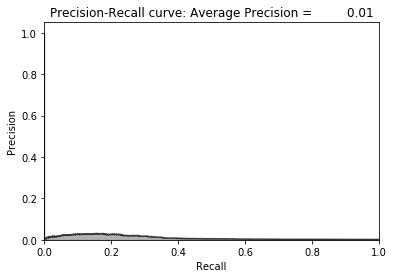

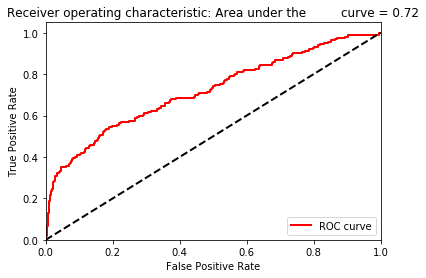

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1400 - accuracy: 0.7855 - val_loss: 0.0402 - val_accuracy: 0.9014
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0576 - accuracy: 0.8859 - val_loss: 0.0363 - val_accuracy: 0.9442
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.8995 - val_loss: 0.0363 - val_accuracy: 0.9538
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0558 - accuracy: 0.9034 - val_loss: 0.0371 - val_accuracy: 0.9566
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.9110 - val_loss: 0.0366 - val_accuracy: 0.9578
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0561 - accuracy: 0.9124 - val_loss: 0.0369 - val_accuracy: 0.9674
Epoch 7/10
190820/190820 [================

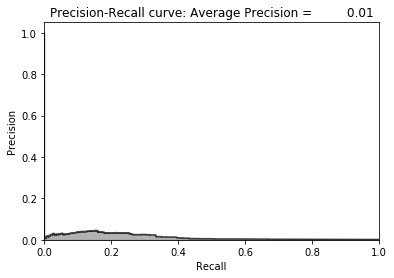

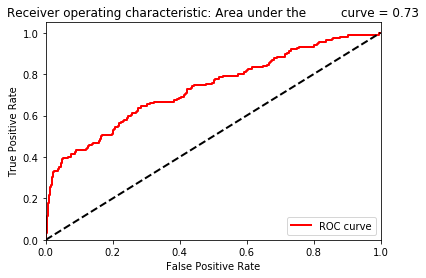

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1231 - accuracy: 0.7906 - val_loss: 0.0396 - val_accuracy: 0.8780
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0573 - accuracy: 0.8677 - val_loss: 0.0358 - val_accuracy: 0.9141
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0567 - accuracy: 0.8810 - val_loss: 0.0359 - val_accuracy: 0.9316
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0553 - accuracy: 0.8883 - val_loss: 0.0378 - val_accuracy: 0.9323
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.8954 - val_loss: 0.0363 - val_accuracy: 0.9447
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0558 - accuracy: 0.9049 - val_loss: 0.0365 - val_accuracy: 0.9564
Epoch 7/10
190820/190820 [================

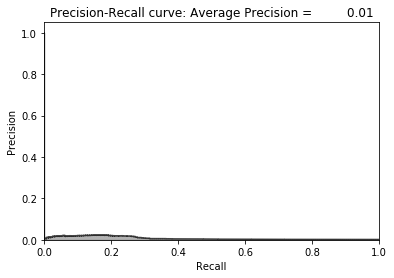

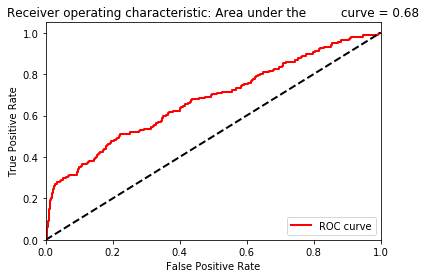

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1366 - accuracy: 0.7841 - val_loss: 0.0389 - val_accuracy: 0.9058
Epoch 2/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0578 - accuracy: 0.8900 - val_loss: 0.0363 - val_accuracy: 0.9324
Epoch 3/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0561 - accuracy: 0.8983 - val_loss: 0.0364 - val_accuracy: 0.9571
Epoch 4/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0557 - accuracy: 0.9053 - val_loss: 0.0376 - val_accuracy: 0.9517
Epoch 5/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0560 - accuracy: 0.9120 - val_loss: 0.0366 - val_accuracy: 0.9544
Epoch 6/10
190820/190820 [==============================] - 7s 36us/sample - loss: 0.0562 - accuracy: 0.9120 - val_loss: 0.0369 - val_accuracy: 0.9661
Epoch 7/10
190820/190820 [================

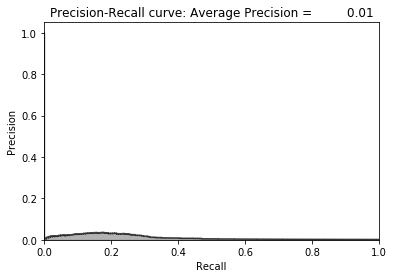

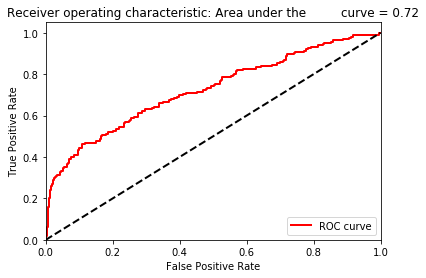

Mean average precision over 10 runs: 0.0134


[0.0345, 0.0084, 0.0102, 0.0159, 0.0137, 0.008, 0.0103, 0.0136, 0.0079, 0.0113]

In [45]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [46]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0134
Coefficient of variation over 10 runs: 0.5613


[0.0345, 0.0084, 0.0102, 0.0159, 0.0137, 0.008, 0.0103, 0.0136, 0.0079, 0.0113]

## Model Ten
#### Two layer denoising overcomplete autoencoder with linear activation
And sparsity regularizer and dropout  
29 -> 40 -> 29  
Dropout percentage: 5%

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1031 - accuracy: 0.8050 - val_loss: 0.0079 - val_accuracy: 0.9716
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0514 - accuracy: 0.8472 - val_loss: 0.0040 - val_accuracy: 0.9855
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0506 - accuracy: 0.8468 - val_loss: 0.0038 - val_accuracy: 0.9868
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0502 - accuracy: 0.8489 - val_loss: 0.0076 - val_accuracy: 0.9746
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0508 - accuracy: 0.8472 - val_loss: 0.0046 - val_accuracy: 0.9845
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0503 - accuracy: 0.8488 - val_loss: 0.0046 - val_accuracy: 0.9827
Epoch 7/10
190820/190820 [================

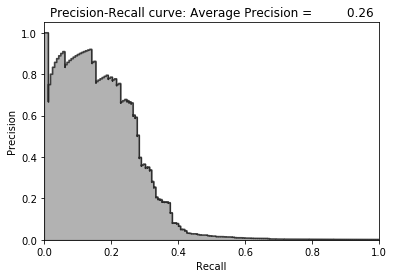

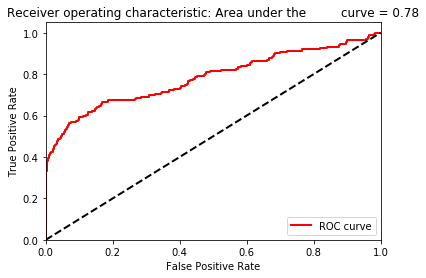

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1043 - accuracy: 0.8067 - val_loss: 0.0071 - val_accuracy: 0.9741
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0523 - accuracy: 0.8477 - val_loss: 0.0040 - val_accuracy: 0.9855
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0513 - accuracy: 0.8472 - val_loss: 0.0038 - val_accuracy: 0.9861
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0501 - accuracy: 0.8484 - val_loss: 0.0073 - val_accuracy: 0.9762
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0508 - accuracy: 0.8483 - val_loss: 0.0044 - val_accuracy: 0.9845
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0502 - accuracy: 0.8491 - val_loss: 0.0049 - val_accuracy: 0.9821
Epoch 7/10
190820/190820 [================

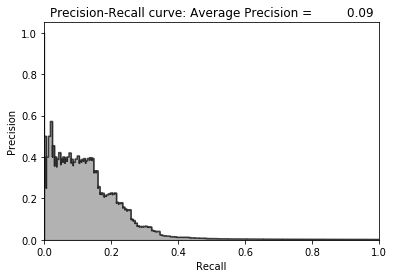

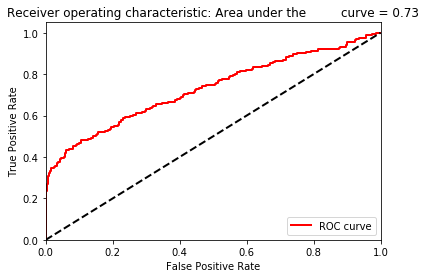

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1015 - accuracy: 0.8074 - val_loss: 0.0062 - val_accuracy: 0.9755
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0524 - accuracy: 0.8481 - val_loss: 0.0040 - val_accuracy: 0.9838
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0514 - accuracy: 0.8490 - val_loss: 0.0038 - val_accuracy: 0.9840
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0497 - accuracy: 0.8490 - val_loss: 0.0078 - val_accuracy: 0.9711
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0509 - accuracy: 0.8489 - val_loss: 0.0043 - val_accuracy: 0.9857
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0504 - accuracy: 0.8492 - val_loss: 0.0041 - val_accuracy: 0.9836
Epoch 7/10
190820/190820 [================

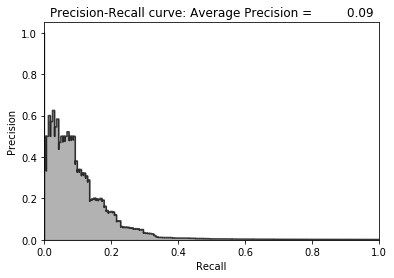

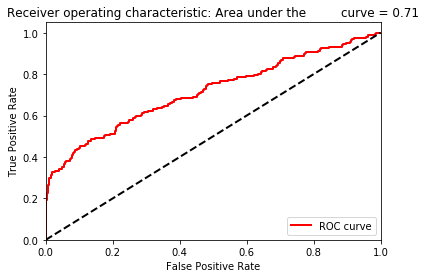

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.1073 - accuracy: 0.8041 - val_loss: 0.0082 - val_accuracy: 0.9703
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0510 - accuracy: 0.8470 - val_loss: 0.0041 - val_accuracy: 0.9807
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0519 - accuracy: 0.8490 - val_loss: 0.0038 - val_accuracy: 0.9840
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0500 - accuracy: 0.8480 - val_loss: 0.0085 - val_accuracy: 0.9683
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0501 - accuracy: 0.8485 - val_loss: 0.0040 - val_accuracy: 0.9868
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0502 - accuracy: 0.8499 - val_loss: 0.0045 - val_accuracy: 0.9814
Epoch 7/10
190820/190820 [================

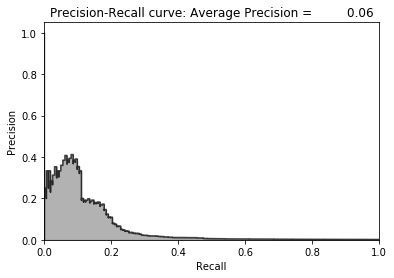

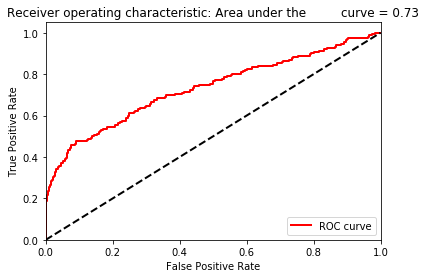

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 39us/sample - loss: 0.1071 - accuracy: 0.8030 - val_loss: 0.0086 - val_accuracy: 0.9671
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0514 - accuracy: 0.8464 - val_loss: 0.0039 - val_accuracy: 0.9863
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0509 - accuracy: 0.8477 - val_loss: 0.0037 - val_accuracy: 0.9847
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0504 - accuracy: 0.8499 - val_loss: 0.0087 - val_accuracy: 0.9697
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0503 - accuracy: 0.8491 - val_loss: 0.0040 - val_accuracy: 0.9869
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0501 - accuracy: 0.8482 - val_loss: 0.0065 - val_accuracy: 0.9762
Epoch 7/10
190820/190820 [================

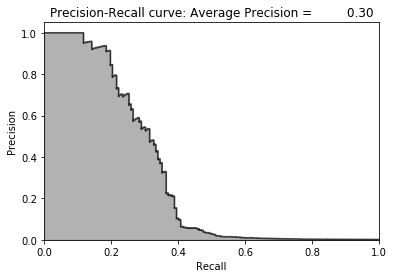

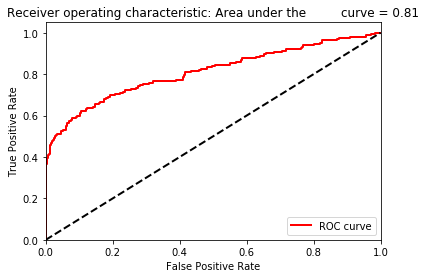

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1076 - accuracy: 0.8035 - val_loss: 0.0084 - val_accuracy: 0.9675
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0520 - accuracy: 0.8483 - val_loss: 0.0040 - val_accuracy: 0.9834
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0511 - accuracy: 0.8482 - val_loss: 0.0038 - val_accuracy: 0.9842
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0489 - accuracy: 0.8486 - val_loss: 0.0066 - val_accuracy: 0.9754
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0511 - accuracy: 0.8484 - val_loss: 0.0044 - val_accuracy: 0.9853
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.0512 - accuracy: 0.8474 - val_loss: 0.0045 - val_accuracy: 0.9804
Epoch 7/10
190820/190820 [================

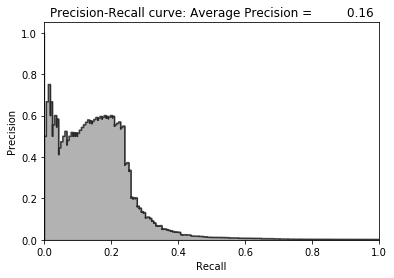

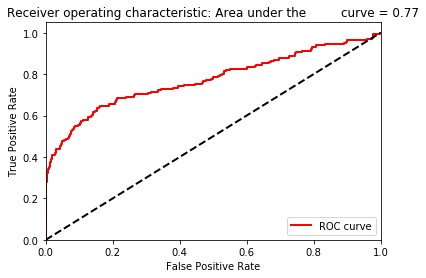

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1066 - accuracy: 0.8020 - val_loss: 0.0075 - val_accuracy: 0.9698
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0510 - accuracy: 0.8471 - val_loss: 0.0040 - val_accuracy: 0.9843
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0526 - accuracy: 0.8479 - val_loss: 0.0037 - val_accuracy: 0.9832
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0503 - accuracy: 0.8485 - val_loss: 0.0072 - val_accuracy: 0.9718
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0506 - accuracy: 0.8501 - val_loss: 0.0043 - val_accuracy: 0.9838
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0495 - accuracy: 0.8478 - val_loss: 0.0061 - val_accuracy: 0.9802
Epoch 7/10
190820/190820 [================

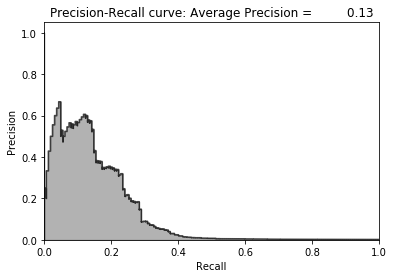

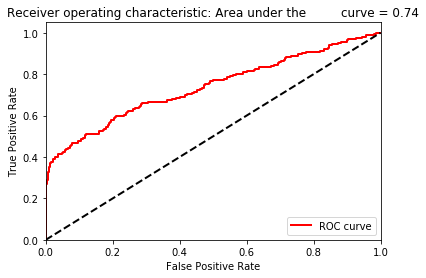

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1040 - accuracy: 0.8054 - val_loss: 0.0065 - val_accuracy: 0.9744
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0508 - accuracy: 0.8486 - val_loss: 0.0039 - val_accuracy: 0.9847
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0516 - accuracy: 0.8492 - val_loss: 0.0038 - val_accuracy: 0.9856
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0501 - accuracy: 0.8494 - val_loss: 0.0089 - val_accuracy: 0.9696
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.0499 - accuracy: 0.8483 - val_loss: 0.0046 - val_accuracy: 0.9837
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0499 - accuracy: 0.8493 - val_loss: 0.0044 - val_accuracy: 0.9790
Epoch 7/10
190820/190820 [================

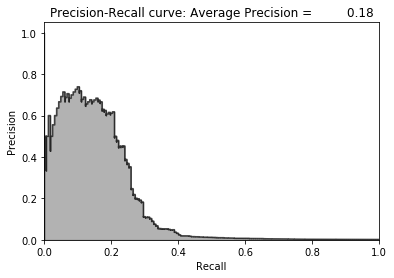

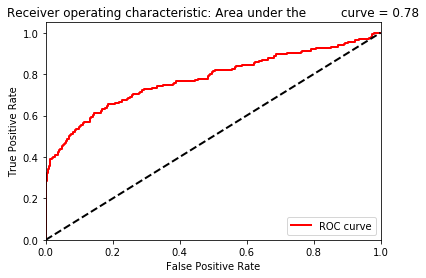

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1044 - accuracy: 0.8030 - val_loss: 0.0070 - val_accuracy: 0.9736
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0518 - accuracy: 0.8479 - val_loss: 0.0039 - val_accuracy: 0.9858
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0513 - accuracy: 0.8497 - val_loss: 0.0039 - val_accuracy: 0.9864
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0495 - accuracy: 0.8491 - val_loss: 0.0080 - val_accuracy: 0.9737
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0511 - accuracy: 0.8477 - val_loss: 0.0043 - val_accuracy: 0.9855
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0509 - accuracy: 0.8470 - val_loss: 0.0044 - val_accuracy: 0.9809
Epoch 7/10
190820/190820 [================

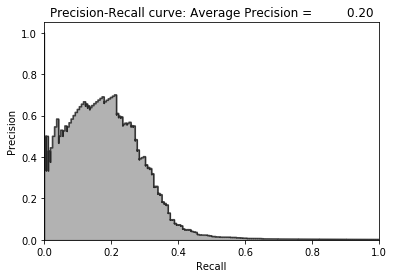

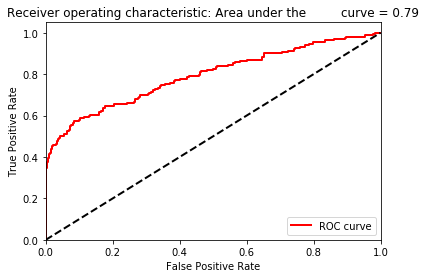

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1045 - accuracy: 0.8066 - val_loss: 0.0072 - val_accuracy: 0.9711
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0515 - accuracy: 0.8480 - val_loss: 0.0040 - val_accuracy: 0.9860
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0508 - accuracy: 0.8476 - val_loss: 0.0038 - val_accuracy: 0.9842
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0498 - accuracy: 0.8489 - val_loss: 0.0067 - val_accuracy: 0.9753
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0502 - accuracy: 0.8484 - val_loss: 0.0042 - val_accuracy: 0.9852
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.0493 - accuracy: 0.8485 - val_loss: 0.0040 - val_accuracy: 0.9838
Epoch 7/10
190820/190820 [================

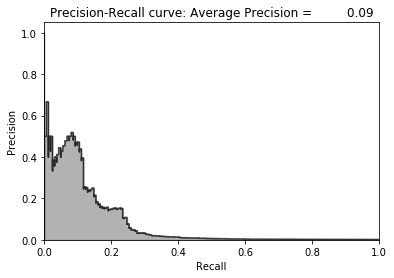

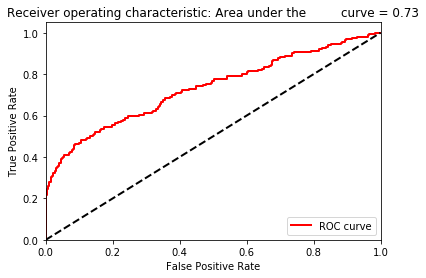

Mean average precision over 10 runs: 0.1565


[0.2624, 0.0938, 0.0857, 0.0632, 0.3049, 0.1603, 0.1307, 0.1763, 0.2025, 0.085]

In [48]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [49]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1565
Coefficient of variation over 10 runs: 0.4917


[0.2624, 0.0938, 0.0857, 0.0632, 0.3049, 0.1603, 0.1307, 0.1763, 0.2025, 0.085]

## Model Eleven
##### Two layer denoising overcomplete autoencoder with ReLU activation
And sparsity regularizer and dropout  
29 -> 40 -> 29  
Dropout percentage: 5%

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2216 - accuracy: 0.6597 - val_loss: 0.0260 - val_accuracy: 0.9091
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1322 - accuracy: 0.7238 - val_loss: 0.0167 - val_accuracy: 0.9224
Epoch 3/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1251 - accuracy: 0.7305 - val_loss: 0.0147 - val_accuracy: 0.9286
Epoch 4/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1193 - accuracy: 0.7347 - val_loss: 0.0144 - val_accuracy: 0.9218
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1181 - accuracy: 0.7370 - val_loss: 0.0138 - val_accuracy: 0.9236
Epoch 6/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1155 - accuracy: 0.7385 - val_loss: 0.0120 - val_accuracy: 0.9303
Epoch 7/10
190820/190820 [================

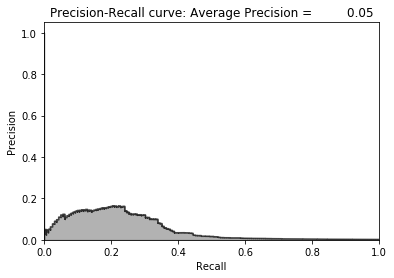

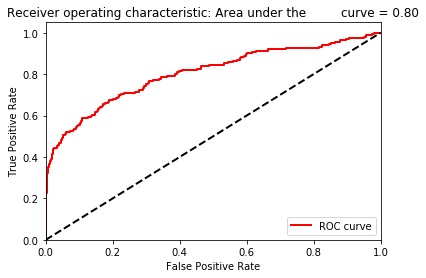

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2167 - accuracy: 0.6604 - val_loss: 0.0245 - val_accuracy: 0.9079
Epoch 2/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1310 - accuracy: 0.7240 - val_loss: 0.0167 - val_accuracy: 0.9242
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1258 - accuracy: 0.7327 - val_loss: 0.0144 - val_accuracy: 0.9300
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1197 - accuracy: 0.7358 - val_loss: 0.0137 - val_accuracy: 0.9296
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1173 - accuracy: 0.7387 - val_loss: 0.0130 - val_accuracy: 0.9283
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1165 - accuracy: 0.7392 - val_loss: 0.0123 - val_accuracy: 0.9274
Epoch 7/10
190820/190820 [================

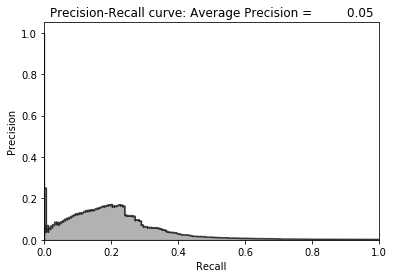

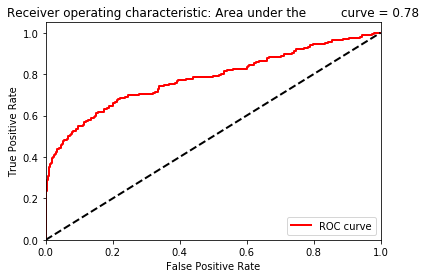

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2194 - accuracy: 0.6615 - val_loss: 0.0242 - val_accuracy: 0.9061
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1323 - accuracy: 0.7221 - val_loss: 0.0171 - val_accuracy: 0.9223
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1234 - accuracy: 0.7298 - val_loss: 0.0148 - val_accuracy: 0.9193
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1204 - accuracy: 0.7353 - val_loss: 0.0136 - val_accuracy: 0.9316
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1171 - accuracy: 0.7363 - val_loss: 0.0126 - val_accuracy: 0.9315
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1156 - accuracy: 0.7393 - val_loss: 0.0123 - val_accuracy: 0.9249
Epoch 7/10
190820/190820 [================

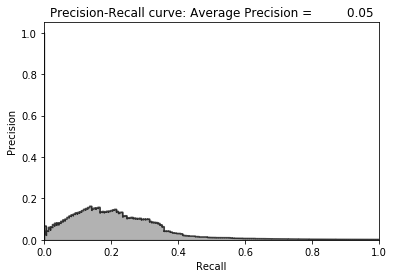

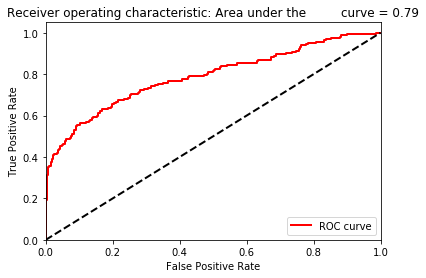

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2221 - accuracy: 0.6612 - val_loss: 0.0255 - val_accuracy: 0.9004
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1313 - accuracy: 0.7235 - val_loss: 0.0163 - val_accuracy: 0.9229
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1219 - accuracy: 0.7315 - val_loss: 0.0142 - val_accuracy: 0.9221
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1153 - accuracy: 0.7364 - val_loss: 0.0137 - val_accuracy: 0.9185
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1147 - accuracy: 0.7367 - val_loss: 0.0127 - val_accuracy: 0.9204
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1114 - accuracy: 0.7385 - val_loss: 0.0120 - val_accuracy: 0.9224
Epoch 7/10
190820/190820 [================

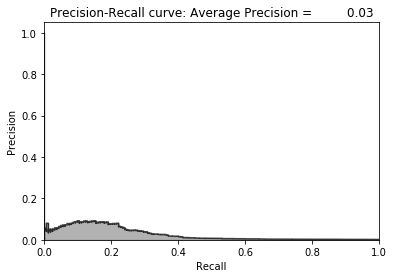

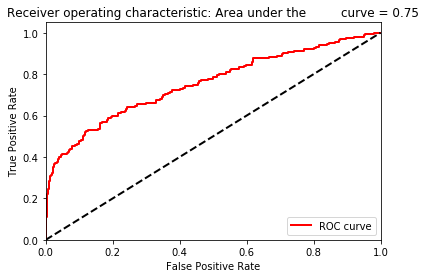

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.2220 - accuracy: 0.6601 - val_loss: 0.0251 - val_accuracy: 0.9108
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1304 - accuracy: 0.7244 - val_loss: 0.0161 - val_accuracy: 0.9254
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1207 - accuracy: 0.7321 - val_loss: 0.0131 - val_accuracy: 0.9306
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1168 - accuracy: 0.7388 - val_loss: 0.0128 - val_accuracy: 0.9295
Epoch 5/10
190820/190820 [==============================] - 7s 37us/sample - loss: 0.1175 - accuracy: 0.7398 - val_loss: 0.0127 - val_accuracy: 0.9236
Epoch 6/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1126 - accuracy: 0.7395 - val_loss: 0.0117 - val_accuracy: 0.9303
Epoch 7/10
190820/190820 [================

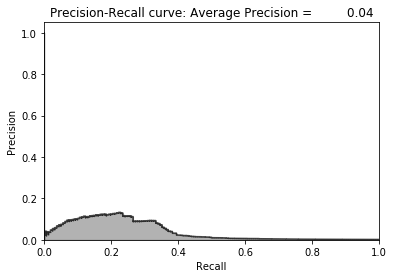

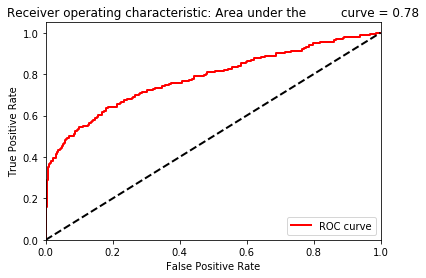

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.2295 - accuracy: 0.6567 - val_loss: 0.0260 - val_accuracy: 0.8989
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1316 - accuracy: 0.7235 - val_loss: 0.0170 - val_accuracy: 0.9263
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1232 - accuracy: 0.7312 - val_loss: 0.0143 - val_accuracy: 0.9270
Epoch 4/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1193 - accuracy: 0.7382 - val_loss: 0.0140 - val_accuracy: 0.9229
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1167 - accuracy: 0.7388 - val_loss: 0.0131 - val_accuracy: 0.9248
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1125 - accuracy: 0.7404 - val_loss: 0.0125 - val_accuracy: 0.9205
Epoch 7/10
190820/190820 [================

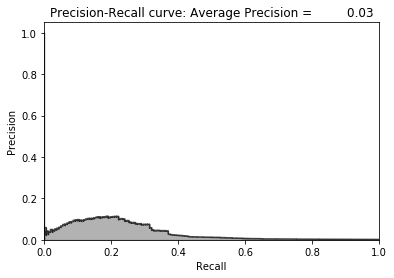

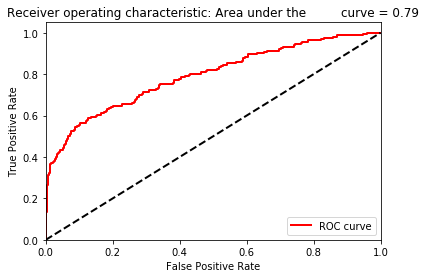

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2274 - accuracy: 0.6551 - val_loss: 0.0274 - val_accuracy: 0.9081
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1334 - accuracy: 0.7212 - val_loss: 0.0171 - val_accuracy: 0.9249
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1261 - accuracy: 0.7313 - val_loss: 0.0147 - val_accuracy: 0.9292
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1203 - accuracy: 0.7337 - val_loss: 0.0139 - val_accuracy: 0.9287
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1237 - accuracy: 0.7375 - val_loss: 0.0133 - val_accuracy: 0.9238
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1145 - accuracy: 0.7402 - val_loss: 0.0123 - val_accuracy: 0.9291
Epoch 7/10
190820/190820 [================

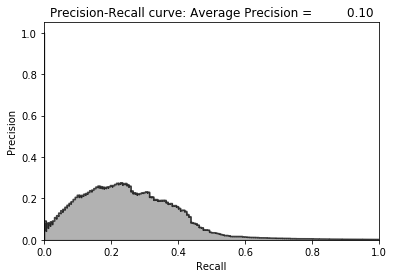

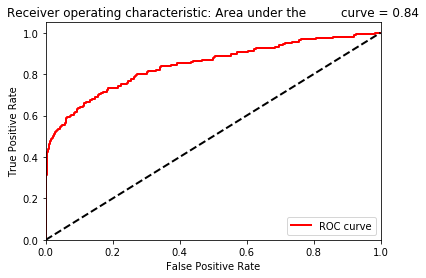

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 40us/sample - loss: 0.2183 - accuracy: 0.6599 - val_loss: 0.0246 - val_accuracy: 0.9073
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1299 - accuracy: 0.7217 - val_loss: 0.0161 - val_accuracy: 0.9185
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1246 - accuracy: 0.7292 - val_loss: 0.0147 - val_accuracy: 0.9255
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1216 - accuracy: 0.7333 - val_loss: 0.0139 - val_accuracy: 0.9200
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1183 - accuracy: 0.7364 - val_loss: 0.0131 - val_accuracy: 0.9271
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1164 - accuracy: 0.7380 - val_loss: 0.0124 - val_accuracy: 0.9281
Epoch 7/10
190820/190820 [================

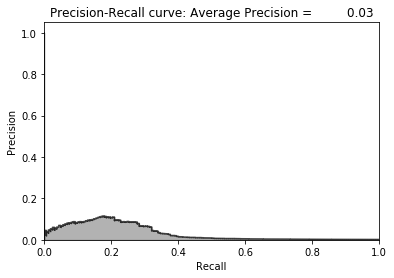

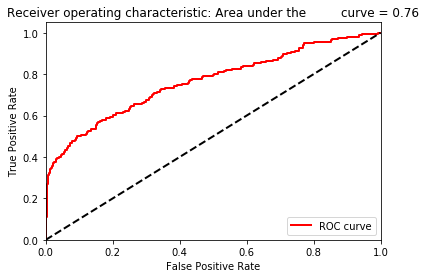

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2202 - accuracy: 0.6604 - val_loss: 0.0263 - val_accuracy: 0.8997
Epoch 2/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1311 - accuracy: 0.7236 - val_loss: 0.0163 - val_accuracy: 0.9244
Epoch 3/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1242 - accuracy: 0.7298 - val_loss: 0.0139 - val_accuracy: 0.9276
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1212 - accuracy: 0.7329 - val_loss: 0.0134 - val_accuracy: 0.9274
Epoch 5/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1175 - accuracy: 0.7351 - val_loss: 0.0134 - val_accuracy: 0.9265
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1143 - accuracy: 0.7382 - val_loss: 0.0122 - val_accuracy: 0.9309
Epoch 7/10
190820/190820 [================

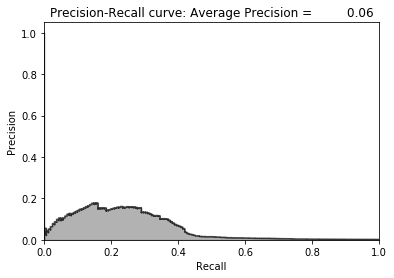

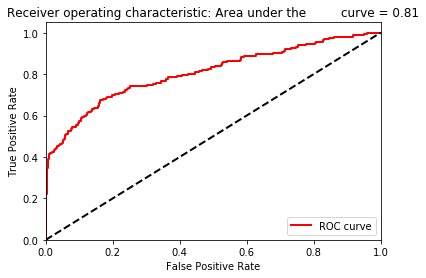

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.2173 - accuracy: 0.6622 - val_loss: 0.0222 - val_accuracy: 0.9097
Epoch 2/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1298 - accuracy: 0.7225 - val_loss: 0.0166 - val_accuracy: 0.9190
Epoch 3/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1232 - accuracy: 0.7298 - val_loss: 0.0147 - val_accuracy: 0.9223
Epoch 4/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1181 - accuracy: 0.7338 - val_loss: 0.0137 - val_accuracy: 0.9244
Epoch 5/10
190820/190820 [==============================] - 7s 39us/sample - loss: 0.1171 - accuracy: 0.7347 - val_loss: 0.0135 - val_accuracy: 0.9226
Epoch 6/10
190820/190820 [==============================] - 7s 38us/sample - loss: 0.1159 - accuracy: 0.7353 - val_loss: 0.0124 - val_accuracy: 0.9249
Epoch 7/10
190820/190820 [================

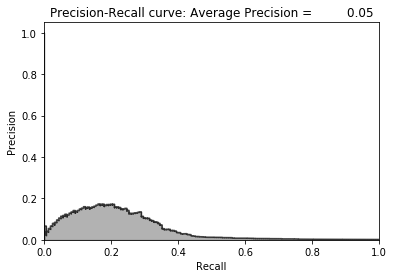

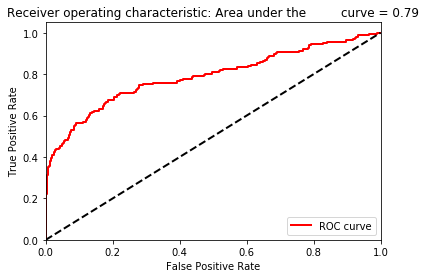

Mean average precision over 10 runs: 0.0482


[0.0513,
 0.0468,
 0.0458,
 0.0264,
 0.0405,
 0.0347,
 0.0952,
 0.0322,
 0.0572,
 0.0521]

In [51]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

#### Results

In [52]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0482
Coefficient of variation over 10 runs: 0.376


[0.0513,
 0.0468,
 0.0458,
 0.0264,
 0.0405,
 0.0347,
 0.0952,
 0.0322,
 0.0572,
 0.0521]